## Разные виды дистилляции

---

Цель лабораторной работы — изучить методы *дистилляции знаний*, которые позволяют обучать компактные нейронные сети (**Student**) с использованием информации от более мощных и точных моделей (**Teacher**).

Дистилляция применяется, когда требуется:

* уменьшить размер модели,
* ускорить инференс,
* сократить вычислительные затраты,
* сохранить максимальную точность при снижении параметров.

В рамках лабораторной работы исследуем различные подходы к дистилляции и сравним их влияние на качество классификации на датасете CIFAR-10.

Базовая идея дистилляции:

> Учитель передаёт Студенту дополнительную информацию (логиты, вероятности, скрытые фичи), что должно облегчить обучение более слабой модели.

---

### 1. Установка зависимостей и импорты

In [55]:
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, top_k_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score
import time
from torch.utils.tensorboard import SummaryWriter
import seaborn as sns

### 2. Загрузка и подготовка данных

В данной лабораторной работе предлагается использовать датасет CIFAR-10.

**CIFAR-10** — это популярный набор данных для задач компьютерного зрения, особенно для обучения и тестирования моделей классификации изображений.

---

### **CIFAR-10: основные характеристики**

**Состав датасета:**

* **60 000 изображений** размера **32×32 пикселя** в **RGB** (3 канала).
* **50 000 изображений** — обучающая выборка (`train=True`).
* **10 000 изображений** — тестовая выборка.
* Изображения *маленькие* и *цветные*.

**Классы (10 категорий):**

1. airplane
2. automobile
3. bird
4. cat
5. deer
6. dog
7. frog
8. horse
9. ship
10. truck

---

### 📌 Формат, который возвращает датасет

Каждый элемент датасета — это пара:

```python
(image_tensor, label)
```

где:

* **image_tensor** — тензор изображения после `transform`
* **label** — число от 0 до 9 (номер класса)

---

In [56]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [57]:
# Определение преобразований для данных
transforms_cifar = transforms.Compose([
                                        transforms.ToTensor(),
                                        transforms.Normalize(mean=mean, std=std),
                                    ])

In [58]:
# Загрузка тренировочного набора данных
trainset = torchvision.datasets.CIFAR10(root='./cifar_data', 
                                        train=True,
                                        download=True, 
                                        transform=transforms_cifar)

In [59]:
# Загрузка тестового набора данных
testset = torchvision.datasets.CIFAR10(root='./cifar_data', 
                                       train=False,
                                       download=True, 
                                       transform=transforms_cifar)

In [60]:
trainset[0][0].shape

torch.Size([3, 32, 32])

In [61]:
BATCH_SIZE = 64

# Создаём DataLoader (чтобы получить батч)
train_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size=BATCH_SIZE,
                                           shuffle=False, 
                                           num_workers=2)


test_loader = torch.utils.data.DataLoader(testset, 
                                          batch_size=BATCH_SIZE,
                                          shuffle=False, 
                                          num_workers=2)

len(train_loader), len(test_loader)

(782, 157)

### 3. Визуализация данных

In [62]:
# Список классов CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [63]:
def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

In [64]:
# Создаём DataLoader (чтобы получить батч)
vizualization_loader = torch.utils.data.DataLoader(trainset, 
                                           batch_size=10,
                                           shuffle=False, 
                                           num_workers=2)

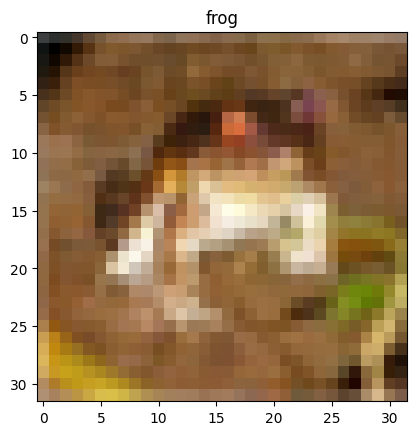

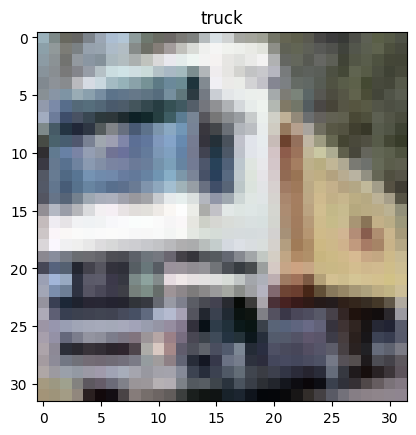

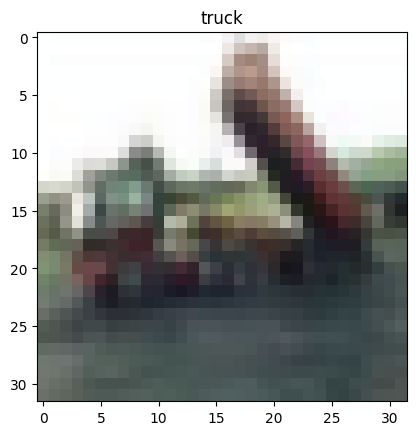

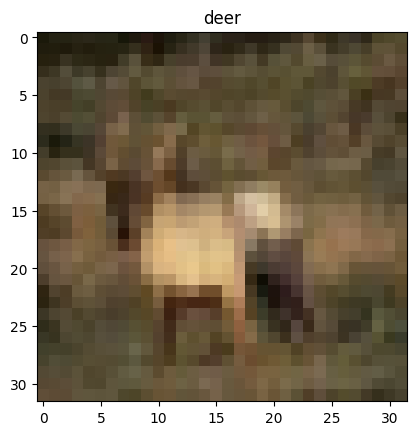

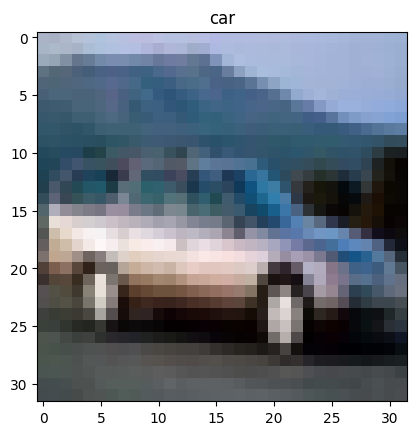

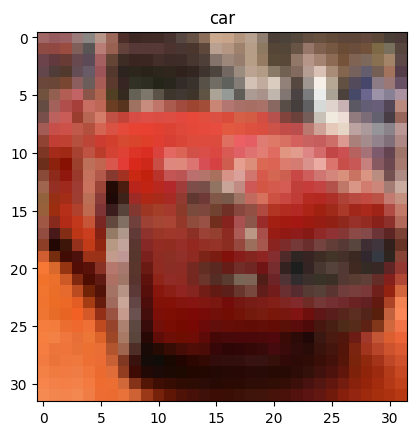

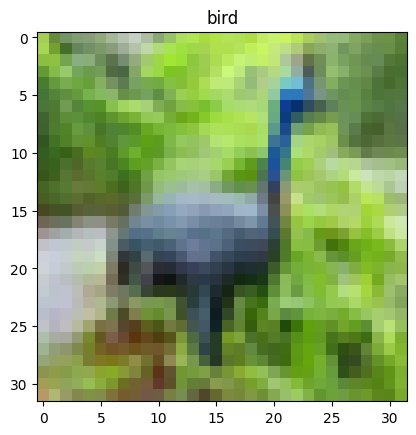

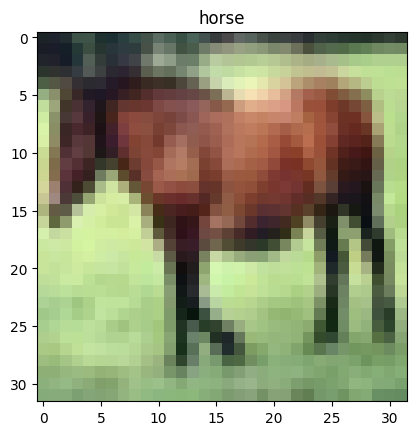

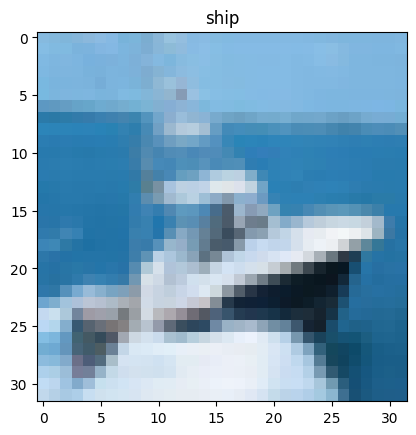

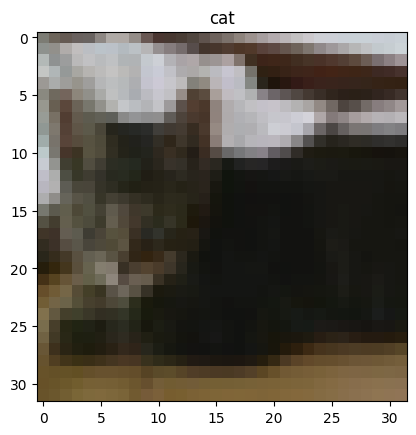

In [65]:
# Визуализируем данные из датасета

X_batch, y_batch = next(iter(vizualization_loader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item,
           title=classes[y_item])

### 4. Архитектура Учителя и Студента

Определим большую модель Учителя и маленькую Студента.

In [66]:
from torchvision.models import resnet50, resnet18, ResNet50_Weights, ResNet18_Weights

In [67]:
# help(resnet50)

In [68]:
teacher_model = resnet50(weights= None)

# Загружаем веса
state_dict = torch.load('./resnet50_weights/resnet50-11ad3fa6.pth')

teacher_model.load_state_dict(state_dict)

# CIFAR-10 имеет 10 классов, поэтому нужно адаптировать последний слой сети
# (ResNet50 по умолчанию рассчитан на 1000 классов ImageNet.)
teacher_model.fc = nn.Linear(2048, 10)

In [69]:
teacher_model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [70]:
# student_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
student_model = resnet18(weights=None)

# Загружаем веса
state_dict = torch.load('./resnet18_weights/resnet18-f37072fd.pth')

student_model.load_state_dict(state_dict)

student_model.fc = nn.Linear(512, 10)

In [71]:
# student_model

#### 5. Функции обучения и валидации

In [72]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [73]:
criterion = nn.CrossEntropyLoss()

In [74]:
LEARNING_RATE = 0.001

teacher_optimizer = optim.AdamW(teacher_model.parameters(), 
                                lr=LEARNING_RATE)

student_optimizer = optim.AdamW(student_model.parameters(), 
                                lr=LEARNING_RATE)

In [75]:
# TensorBoard
writer = SummaryWriter(log_dir='runs/baseline')

In [76]:
!tensorboard --logdir=runs/baseline

/bin/bash: tensorboard: command not found


In [77]:
def train(model, num_epochs, train_loader, val_loader, optimizer, criterion, device, class_names):
    model.to(device)

    # История обучения
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'total_time':0
    }

    total_start = time.time()

    for epoch in range(num_epochs):
        # ---------- ОБУЧЕНИЕ ----------
        model.train()
        running_loss = 0.0

        train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] (train)", leave=False)
        for inputs, targets in train_loop:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_loop.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)

        # ---------- ВАЛИДАЦИЯ ----------
        model.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []

        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] (val)", leave=False)
            for inputs, targets in val_loop:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(targets.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
        val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        # ---------- ЛОГИРОВАНИЕ ----------
        writer.add_scalar("Loss/Train", avg_train_loss, epoch)
        writer.add_scalar("Loss/Val", avg_val_loss, epoch)
        writer.add_scalar("Accuracy/Val", val_accuracy, epoch)
        writer.add_scalar("Precision/Val", val_precision, epoch)
        writer.add_scalar("Recall/Val", val_recall, epoch)
        writer.add_scalar("F1/Val", val_f1, epoch)

        # Добавим примеры изображений в TensorBoard (раз в 5 эпох)
        if epoch % 5 == 0:
            imgs_grid = torchvision.utils.make_grid(inputs[:8].cpu(), normalize=True)
            writer.add_image("Sample Images", imgs_grid, epoch)

        # ---------- СОХРАНЕНИЕ В ИСТОРИЮ ----------
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.2f}% | "
              f"Val Precision: {val_precision:.2f}% | "
              f"Val Recall: {val_recall:.2f}% | "
              f"Val F1: {val_f1:.3f}")

    total_time = time.time() - total_start
    
    history['total_time'] = total_time
    
    print(f"\nОбучение завершено за {total_time/60:.2f} мин ({total_time:.1f} сек)")
    
    writer.close()

    return history


In [78]:
def evaluate_metrics(model, dataloader, device, class_names, show_matrix=True, save_path=None):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Accuracy
    acc = accuracy_score(all_labels, all_preds)
    

    # Classification report
    print("📊 Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("🔹 Confusion Matrix:")
    # print(cm)

    # ----- Визуализация -----
    if show_matrix:
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names,
                    yticklabels=class_names)
        plt.xlabel('Предсказанный класс')
        plt.ylabel('Истинный класс')
        plt.title(f'Confusion Matrix — Accuracy: {acc:.2f}')
        plt.tight_layout()

        if save_path:
            plt.savefig(save_path, dpi=300)
            print(f"✅ Матрица сохранена в {save_path}")
        plt.show()

    print(f"✅ Accuracy: {acc:.4f}")

    return {
        "accuracy": acc,
        # "top5_accuracy": top5_acc,
        "confusion_matrix": cm
    }

In [79]:
def summarize_history(history: dict, model_name: str = "ResNet18", method:str = None) -> dict:
    """
    Усредняет все значения истории обучения (кроме total_time)
    и добавляет имя модели.

    Args:
        history (dict): История обучения (train_loss, val_acc, total_time и т.д.)
        model_name (str): Название модели, которое будет добавлено в результат.

    Returns:
        dict: Словарь с усреднёнными метриками и именем модели.
    """
    averages = {
        k: round(np.mean(v), 3) if isinstance(v, list) else round(v, 3)
        for k, v in history.items()
    }

    averages["model"] = model_name
    averages["method"] = method
    return averages

In [80]:
EPOCHS = 10

### 6. BASELINE: Обучение модели

1. Обучить архитектуру, которая далее будет считаться Учителем.
2. Обучить архитектуру, которая далее будет считаться Студентом. Архитектура должна быть слабее Учителя.
3. Сравнить метрики.


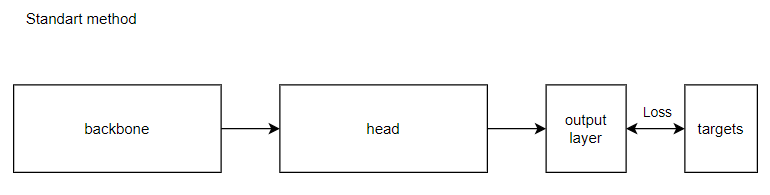


### **Цель**

Получить базовые метрики для мощной модели (ResNet50) и компактной модели (ResNet18). Эти результаты используются как:

* **Upper bound** — максимальная точность (Teacher)
* **Baseline** — точность студента без дистилляции

### **Что должно улучшиться**

Здесь ничего не должно улучшаться — это просто исходная точка.
Все последующие методы дистилляции должны пытаться приблизить ResNet18 к качеству ResNet50.

Обучим модель Учителя (архитектура ResNet50)

In [81]:
history = train(model = teacher_model, 
                num_epochs=EPOCHS,
                train_loader=train_loader,
                val_loader=test_loader,
                optimizer=teacher_optimizer,
                criterion=criterion,
                device=device,
                class_names=classes)


# Общее время: 66.32 мин (3979.0 сек) BATCH_SIZE = 10 EPOCHS = 40
# Общее время: 11.12 мин (667.0 сек)  BATCH_SIZE = 64 EPOCHS = 40 

Epoch [1/10] Train Loss: 0.8429 | Val Loss: 0.6009 | Val Acc: 80.31% | Val Precision: 0.80% | Val Recall: 0.80% | Val F1: 0.800


Epoch [2/10] Train Loss: 0.5062 | Val Loss: 0.5883 | Val Acc: 81.35% | Val Precision: 0.82% | Val Recall: 0.81% | Val F1: 0.812


Epoch [3/10] Train Loss: 0.3986 | Val Loss: 0.5216 | Val Acc: 82.63% | Val Precision: 0.83% | Val Recall: 0.83% | Val F1: 0.826


Epoch [4/10] Train Loss: 0.3052 | Val Loss: 0.5888 | Val Acc: 81.98% | Val Precision: 0.82% | Val Recall: 0.82% | Val F1: 0.818


Epoch [5/10] Train Loss: 0.2542 | Val Loss: 0.6577 | Val Acc: 80.81% | Val Precision: 0.82% | Val Recall: 0.81% | Val F1: 0.811


Epoch [6/10] Train Loss: 0.2213 | Val Loss: 0.5910 | Val Acc: 82.80% | Val Precision: 0.83% | Val Recall: 0.83% | Val F1: 0.828


Epoch [7/10] Train Loss: 0.1810 | Val Loss: 0.6852 | Val Acc: 82.80% | Val Precision: 0.83% | Val Recall: 0.83% | Val F1: 0.828


Epoch [8/10] Train Loss: 0.1538 | Val Loss: 0.6766 | Val Acc: 83.38% | Val Precision: 0.84% | Val Recall: 0.83% | Val F1: 0.835


Epoch [9/10] Train Loss: 0.1375 | Val Loss: 0.6464 | Val Acc: 83.85% | Val Precision: 0.84% | Val Recall: 0.84% | Val F1: 0.838


Epoch [10/10] Train Loss: 0.1262 | Val Loss: 0.6377 | Val Acc: 84.24% | Val Precision: 0.84% | Val Recall: 0.84% | Val F1: 0.842

Обучение завершено за 2.83 мин (169.8 сек)


In [82]:
history

{'train_loss': [0.842921544028365,
  0.5061655329811908,
  0.39862612488172244,
  0.3051612272172633,
  0.25420399469887967,
  0.2212833511116712,
  0.18101045041275984,
  0.15377291255985456,
  0.13748213464675277,
  0.12618967998163094],
 'val_loss': [0.6008529382146848,
  0.5882643326452583,
  0.5216241512139133,
  0.5888283881032543,
  0.6577498469572918,
  0.5910496337778249,
  0.6851576700521882,
  0.6766202392851471,
  0.6464148410566294,
  0.6376916853960153],
 'val_acc': [np.float64(80.31),
  np.float64(81.35),
  np.float64(82.63000000000001),
  np.float64(81.98),
  np.float64(80.81),
  np.float64(82.8),
  np.float64(82.8),
  np.float64(83.38),
  np.float64(83.85000000000001),
  np.float64(84.24000000000001)],
 'val_precision': [np.float64(0.8030644782288705),
  np.float64(0.8169866578900006),
  np.float64(0.8337713348225355),
  np.float64(0.8205193813826985),
  np.float64(0.8199908270258037),
  np.float64(0.8288844680460012),
  np.float64(0.8338522102449109),
  np.float64(0.8

In [83]:
avg_history_teacher = summarize_history(history, model_name="ResNet50", method = 'Стандартное обучение')
avg_history_teacher

{'train_loss': np.float64(0.313),
 'val_loss': np.float64(0.619),
 'val_acc': np.float64(82.415),
 'val_precision': np.float64(0.828),
 'val_recall': np.float64(0.824),
 'val_f1': np.float64(0.824),
 'total_time': 169.76,
 'model': 'ResNet50',
 'method': 'Стандартное обучение'}

In [84]:
# torch.save(teacher_model.state_dict(), "./experiments_hw4/model_weights_TEACHER_standard_method.pth")

# teacher_model.load_state_dict(torch.load("./experiments_hw4/model_weights_TEACHER_standard_method.pth"))
# teacher_model.eval()  

In [159]:
def plot_training_history(history):
    # --- Loss ---
    plt.figure(figsize=(10,5))
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.legend()
    plt.grid()
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

    # --- Accuracy ---
    plt.figure(figsize=(10,5))
    plt.plot(history['val_acc'], label='Accuracy')
    plt.legend()
    plt.grid()
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.show()

    # --- Metrics ---
    plt.figure(figsize=(10,5))
    plt.plot(history['val_f1'], label='F1-score')
    plt.plot(history['val_precision'], label='Precision')
    plt.plot(history['val_recall'], label='Recall')
    plt.legend()
    plt.grid()
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.show()

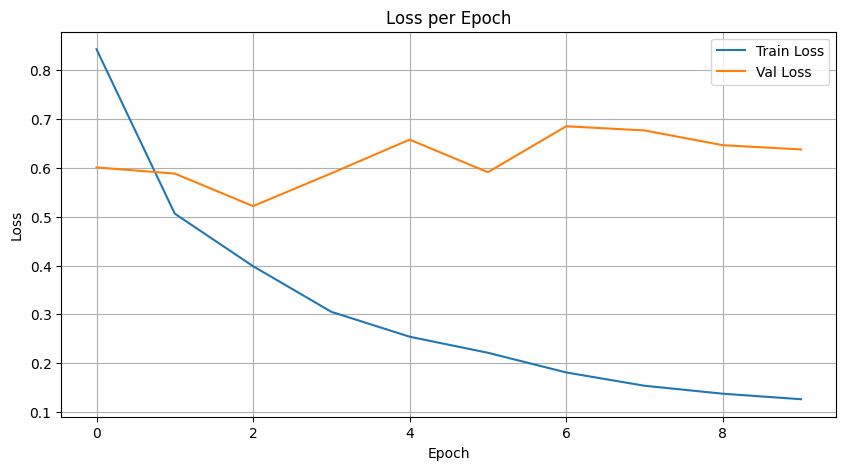

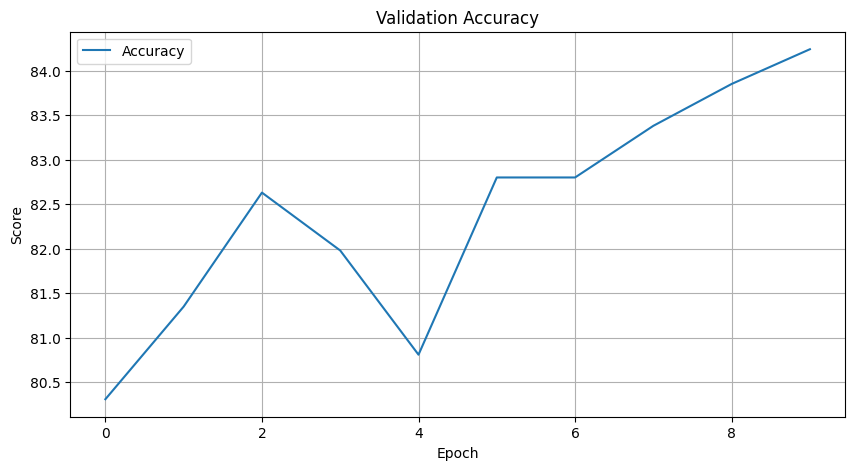

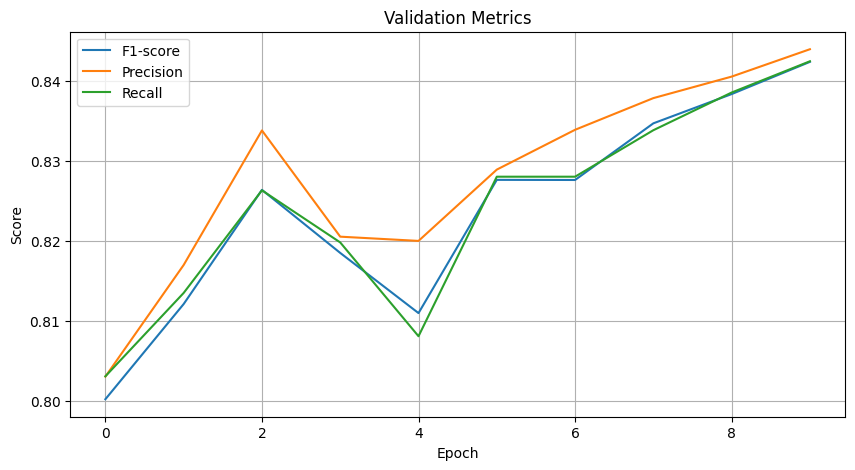

In [160]:
plot_training_history(history)

📊 Classification Report:
              precision    recall  f1-score   support

       plane       0.82      0.89      0.86      1000
         car       0.88      0.93      0.91      1000
        bird       0.78      0.83      0.81      1000
         cat       0.70      0.71      0.71      1000
        deer       0.82      0.81      0.81      1000
         dog       0.80      0.73      0.77      1000
        frog       0.89      0.91      0.90      1000
       horse       0.90      0.86      0.88      1000
        ship       0.91      0.91      0.91      1000
       truck       0.94      0.83      0.88      1000

    accuracy                           0.84     10000
   macro avg       0.84      0.84      0.84     10000
weighted avg       0.84      0.84      0.84     10000

🔹 Confusion Matrix:


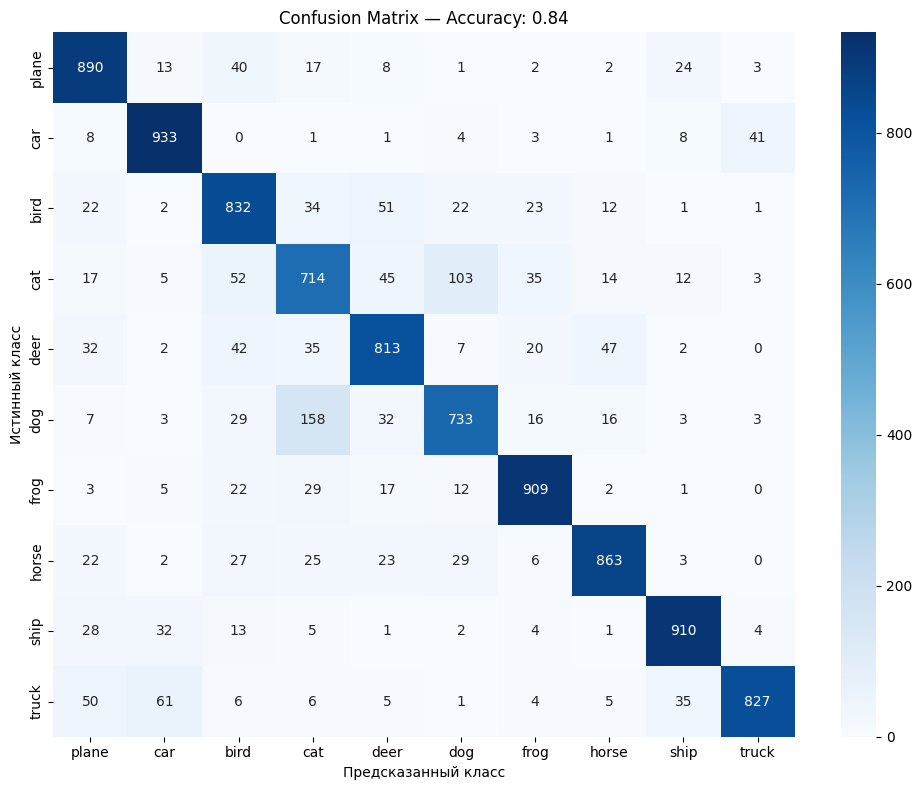

✅ Accuracy: 0.8424


{'accuracy': 0.8424,
 'confusion_matrix': array([[890,  13,  40,  17,   8,   1,   2,   2,  24,   3],
        [  8, 933,   0,   1,   1,   4,   3,   1,   8,  41],
        [ 22,   2, 832,  34,  51,  22,  23,  12,   1,   1],
        [ 17,   5,  52, 714,  45, 103,  35,  14,  12,   3],
        [ 32,   2,  42,  35, 813,   7,  20,  47,   2,   0],
        [  7,   3,  29, 158,  32, 733,  16,  16,   3,   3],
        [  3,   5,  22,  29,  17,  12, 909,   2,   1,   0],
        [ 22,   2,  27,  25,  23,  29,   6, 863,   3,   0],
        [ 28,  32,  13,   5,   1,   2,   4,   1, 910,   4],
        [ 50,  61,   6,   6,   5,   1,   4,   5,  35, 827]])}

In [86]:
evaluate_metrics(teacher_model, 
                 test_loader, 
                 device, 
                 classes)

| Класс | Precision | Recall | F1-score | Комментарий                                                                                    |
| ----- | --------- | ------ | -------- | ---------------------------------------------------------------------------------------------- |
| plane | 0.82      | 0.89   | 0.86     | Небольшая недооценка precision, но хороший recall — большинство самолетов правильно распознаны |
| car   | 0.88      | 0.93   | 0.91     | Отличные показатели — модель хорошо различает автомобили                                       |
| bird  | 0.78      | 0.83   | 0.81     | Средняя точность, есть путаница с похожими животными                                           |
| cat   | 0.70      | 0.71   | 0.71     | Наиболее слабый класс — многие кошки путаются с собаками и другими животными                   |
| deer  | 0.82      | 0.81   | 0.81     | Достаточно сбалансировано                                                                      |
| dog   | 0.80      | 0.73   | 0.77     | Низкий recall — модель пропускает часть собак, вероятно путает с кошками                       |
| frog  | 0.89      | 0.91   | 0.90     | Отличные показатели — модель хорошо распознаёт лягушек                                         |
| horse | 0.90      | 0.86   | 0.88     | Хорошо, но есть небольшая недооценка recall                                                    |
| ship  | 0.91      | 0.91   | 0.91     | Очень хорошо — транспортные средства четко различаются                                         |
| truck | 0.94      | 0.83   | 0.88     | Высокая precision, но часть грузовиков путается с автомобилями (низкий recall)                 |

Обучим модель Студента (архитектура ResNet18)

In [87]:
history_student = train(model = student_model, 
                        num_epochs=EPOCHS,
                        train_loader=train_loader,
                        val_loader=test_loader,
                        optimizer=student_optimizer,
                        criterion=criterion,
                        device=device,
                        class_names=classes)
# Общее время: 29.31 мин (1758.6 сек) BATCH_SIZE = 10 EPOCHS = 40
# Общее время: 2.56 мин (153.3 сек) BATCH_SIZE = 64 EPOCHS = 40

Epoch [1/10] Train Loss: 0.9701 | Val Loss: 0.8680 | Val Acc: 71.26% | Val Precision: 0.73% | Val Recall: 0.71% | Val F1: 0.710


Epoch [2/10] Train Loss: 0.6489 | Val Loss: 0.7170 | Val Acc: 76.63% | Val Precision: 0.77% | Val Recall: 0.77% | Val F1: 0.763


Epoch [3/10] Train Loss: 0.4968 | Val Loss: 0.7069 | Val Acc: 77.16% | Val Precision: 0.78% | Val Recall: 0.77% | Val F1: 0.772


Epoch [4/10] Train Loss: 0.3898 | Val Loss: 0.7348 | Val Acc: 77.85% | Val Precision: 0.79% | Val Recall: 0.78% | Val F1: 0.779


Epoch [5/10] Train Loss: 0.3126 | Val Loss: 0.7393 | Val Acc: 78.57% | Val Precision: 0.79% | Val Recall: 0.79% | Val F1: 0.787


Epoch [6/10] Train Loss: 0.2411 | Val Loss: 0.8469 | Val Acc: 77.68% | Val Precision: 0.79% | Val Recall: 0.78% | Val F1: 0.776


Epoch [7/10] Train Loss: 0.1949 | Val Loss: 0.9272 | Val Acc: 76.98% | Val Precision: 0.79% | Val Recall: 0.77% | Val F1: 0.771


Epoch [8/10] Train Loss: 0.1651 | Val Loss: 0.8201 | Val Acc: 80.12% | Val Precision: 0.80% | Val Recall: 0.80% | Val F1: 0.802


Epoch [9/10] Train Loss: 0.1347 | Val Loss: 0.8998 | Val Acc: 78.97% | Val Precision: 0.80% | Val Recall: 0.79% | Val F1: 0.791


Epoch [10/10] Train Loss: 0.1176 | Val Loss: 0.8982 | Val Acc: 79.50% | Val Precision: 0.81% | Val Recall: 0.79% | Val F1: 0.798

Обучение завершено за 1.31 мин (78.6 сек)


In [88]:
history_student

{'train_loss': [0.9701487324807955,
  0.648899837680485,
  0.4967724259399697,
  0.3898373134910603,
  0.31261858216408267,
  0.24113700197309332,
  0.19489076490159077,
  0.16512847617935494,
  0.1347080065673479,
  0.11762964864835486],
 'val_loss': [0.8679680137117957,
  0.7169722178179747,
  0.706933062167684,
  0.7348067978764795,
  0.739304639161772,
  0.8468753148795692,
  0.9271758043082656,
  0.8200731333463814,
  0.89982895961233,
  0.8982057989023293],
 'val_acc': [np.float64(71.26),
  np.float64(76.63),
  np.float64(77.16),
  np.float64(77.85),
  np.float64(78.57),
  np.float64(77.68),
  np.float64(76.98),
  np.float64(80.12),
  np.float64(78.97),
  np.float64(79.5)],
 'val_precision': [np.float64(0.7310068551101191),
  np.float64(0.7710890686802195),
  np.float64(0.7782662391555971),
  np.float64(0.7866889029539335),
  np.float64(0.792224352458972),
  np.float64(0.7865386735166575),
  np.float64(0.7893688392030269),
  np.float64(0.8041167395687789),
  np.float64(0.79775004

In [89]:
avg_history_student = summarize_history(history_student, model_name="ResNet18", method = 'Стандартное обучение')
avg_history_student

{'train_loss': np.float64(0.367),
 'val_loss': np.float64(0.816),
 'val_acc': np.float64(77.472),
 'val_precision': np.float64(0.784),
 'val_recall': np.float64(0.775),
 'val_f1': np.float64(0.775),
 'total_time': 78.563,
 'model': 'ResNet18',
 'method': 'Стандартное обучение'}

In [90]:
torch.save(student_model.state_dict(), "./experiments_hw4/model_weights_STUDENT_standard_method.pth")

# student_model.load_state_dict(torch.load("./experiments_hw4/model_weights_STUDENT_standard_method.pth"))
# student_model.eval() 

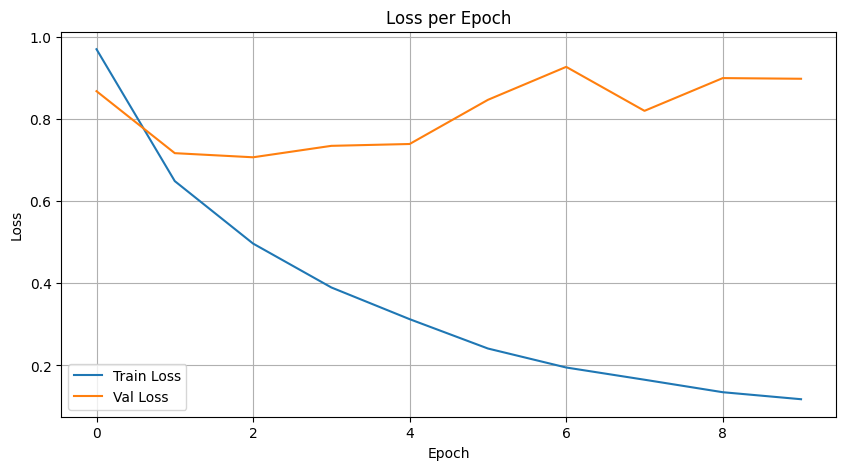

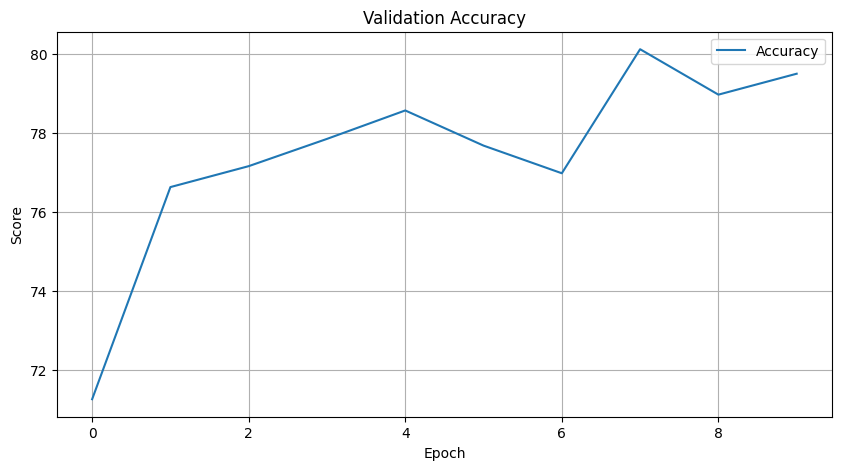

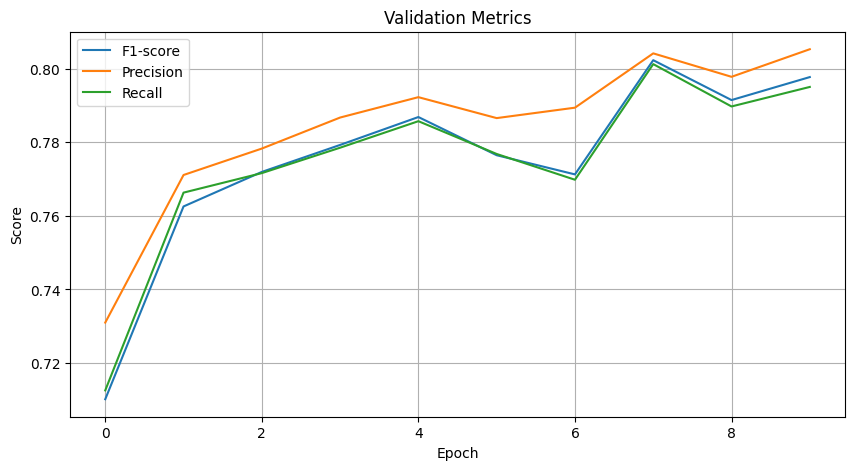

In [161]:
plot_training_history(history_student)

📊 Classification Report:
              precision    recall  f1-score   support

       plane       0.84      0.81      0.83      1000
         car       0.91      0.87      0.89      1000
        bird       0.79      0.70      0.74      1000
         cat       0.54      0.74      0.63      1000
        deer       0.82      0.74      0.78      1000
         dog       0.69      0.66      0.68      1000
        frog       0.86      0.85      0.86      1000
       horse       0.89      0.81      0.84      1000
        ship       0.85      0.91      0.88      1000
       truck       0.87      0.86      0.86      1000

    accuracy                           0.80     10000
   macro avg       0.81      0.79      0.80     10000
weighted avg       0.81      0.80      0.80     10000

🔹 Confusion Matrix:


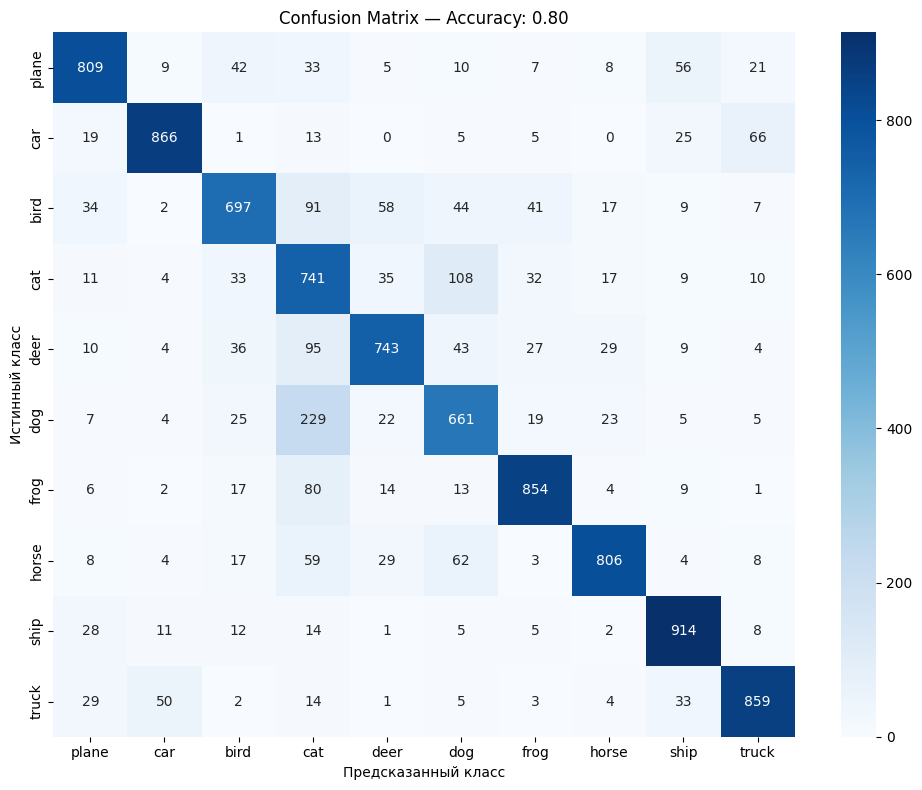

✅ Accuracy: 0.7950


{'accuracy': 0.795,
 'confusion_matrix': array([[809,   9,  42,  33,   5,  10,   7,   8,  56,  21],
        [ 19, 866,   1,  13,   0,   5,   5,   0,  25,  66],
        [ 34,   2, 697,  91,  58,  44,  41,  17,   9,   7],
        [ 11,   4,  33, 741,  35, 108,  32,  17,   9,  10],
        [ 10,   4,  36,  95, 743,  43,  27,  29,   9,   4],
        [  7,   4,  25, 229,  22, 661,  19,  23,   5,   5],
        [  6,   2,  17,  80,  14,  13, 854,   4,   9,   1],
        [  8,   4,  17,  59,  29,  62,   3, 806,   4,   8],
        [ 28,  11,  12,  14,   1,   5,   5,   2, 914,   8],
        [ 29,  50,   2,  14,   1,   5,   3,   4,  33, 859]])}

In [92]:
evaluate_metrics(student_model, 
                 test_loader, 
                 device, 
                 classes)

| Класс | Precision | Recall | F1-score | Комментарий                                                                              |
| ----- | --------- | ------ | -------- | ---------------------------------------------------------------------------------------- |
| plane | 0.84      | 0.81   | 0.83     | Небольшой спад recall, модель стала чаще ошибаться с транспортными классами              |
| car   | 0.91      | 0.87   | 0.89     | Хорошие показатели, но F1 немного ниже, чем в предыдущем отчёте                          |
| bird  | 0.79      | 0.70   | 0.74     | Значительное падение recall, модель пропускает много птиц                                |
| cat   | 0.54      | 0.74   | 0.63     | Сильное падение precision, модель часто ошибочно классифицирует другие объекты как кошек |
| deer  | 0.82      | 0.74   | 0.78     | Ухудшение recall, модель путает оленей с другими животными                               |
| dog   | 0.69      | 0.66   | 0.68     | Падение precision и recall — трудный класс для модели                                    |
| frog  | 0.86      | 0.85   | 0.86     | Осталась стабильной — хороший результат                                                  |
| horse | 0.89      | 0.81   | 0.84     | Slight падение recall, в целом модель различает лошадей хорошо                           |
| ship  | 0.85      | 0.91   | 0.88     | Хорошо, транспортные классы стабильны                                                    |
| truck | 0.87      | 0.86   | 0.86     | Небольшое падение по сравнению с baseline                                                |


In [93]:
df_standard_method = pd.DataFrame([avg_history_teacher, avg_history_student])
df_standard_method

,train_loss,val_loss,val_acc,val_precision,val_recall,val_f1,total_time,model,method
0,0.313,0.619,82.415,0.828,0.824,0.824,169.760,ResNet50,Стандартное обучение
1,0.367,0.816,77.472,0.784,0.775,0.775,78.563,ResNet18,Стандартное обучение


### **Вывод по baseline-экспериментам**

В базовой постановке задачи были обучены две архитектуры — **ResNet50** и более лёгкая **ResNet18** — без применения методов дистилляции. Как и ожидалось, более глубокая модель показала лучшие результаты по всем основным метрикам качества.

**ResNet50** достигла:

* **82.4% accuracy**
* высоких значений precision/recall/F1 (≈0.82),
* при этом обучение заняло больше времени (**~170 сек**).

**ResNet18**, как более компактная архитектура, обучалась примерно в два раза быстрее, однако качество оказалось ниже:

* **77.5% accuracy**,
* F1 ≈ 0.77,
* что на 5% хуже по точности и ~6% по F1-мере.

Таким образом, baseline-эксперименты демонстрируют ожидаемый компромисс между скоростью и качеством: **ResNet50 обеспечивает более высокую точность за счёт увеличенной вычислительной стоимости**, тогда как **ResNet18** служит подходящей лёгкой моделью-кандидатом для последующей дистилляции.


### 7. Эксперимент 1 - Дистилляция логитов

1. Измените тренировочный цикл так, чтобы параллельно в две архитектуры подавались семплы, при этом в Учителе должно быть отколючено обновление градиентов (torch.no_grad()).
2. Изменить функцию ошибки.


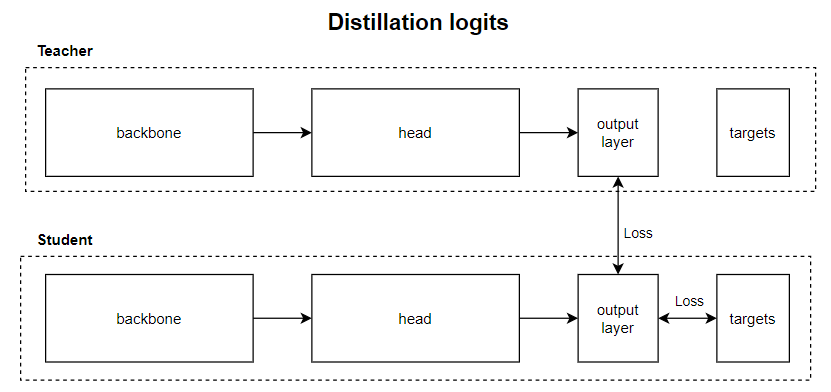

### **Суть метода**

Teacher генерирует “мягкие вероятности” (soft labels) при помощи повышенной температуры T.
Student обучается одновременно:

* на обычных метках (Cross-Entropy),
* и на смягчённых логитах учителя (KL Divergence).

### **Цель**

Использовать знания Учителя о межклассовых отношениях:

* какие классы похожи между собой,
* какие объекты вероятнее всего перепутать,

Это должно помочь student лучше обобщать и не переобучаться.

### **Ожидаемое улучшение**

* Повышение точности студента относительно baseline.

---

## Что нужно изменить

### Подавать входы **в обе модели одновременно**

* Учитель — в `torch.no_grad()` (градиенты не считаем).
* Студент — обучается по новой функции потерь.

### Изменить **функцию ошибки (distillation loss)**

Формула потерь:


$$L = (1 - \alpha) \cdot CE(y_s, y_{true}) + \alpha \cdot T^2 \cdot KLDivLoss(p_s^T, p_t^T)$$


где:

* ( $CE$ ) — обычная кросс-энтропия;
* ( $KLDivLoss$ ) — расхождение Кульбака–Лейблера между распределениями Учителя и Студента;
* ( $T$ ) — температура (обычно 2–5);
* ( $\alpha$ ) — коэффициент, задающий баланс (0.5 — часто оптимален).

Параметры типа:

* температура **T**
* вес **alpha**

нужно отдельно подбирать.

Обычно:

* T = 2–4 для ResNet
* alpha = 0.3–0.7

Если T слишком большой → градиенты становятся "плоскими"
Если alpha слишком большой → student слишком копирует teacher, а teacher обучен на **других входах (ImageNet)** или с совершенно другой динамикой обучения.

---

In [199]:
teacher_model = resnet50(weights= None)

# Загружаем веса
state_dict = torch.load('./resnet50_weights/resnet50-11ad3fa6.pth')

teacher_model.load_state_dict(state_dict)

# CIFAR-10 имеет 10 классов, поэтому нужно адаптировать последний слой сети
# (ResNet50 по умолчанию рассчитан на 1000 классов ImageNet.)
teacher_model.fc = nn.Linear(2048, 10)

In [200]:
student_model = resnet18(weights=None)

# Загружаем веса
state_dict = torch.load('./resnet18_weights/resnet18-f37072fd.pth')

student_model.load_state_dict(state_dict)

student_model.fc = nn.Linear(512, 10)

In [201]:
LEARNING_RATE = 0.001

teacher_optimizer = optim.AdamW(teacher_model.parameters(), 
                                lr=LEARNING_RATE)

student_optimizer = optim.AdamW(student_model.parameters(), 
                                lr=LEARNING_RATE)

In [202]:
EPOCHS = 10

In [203]:
def distillation_loss(student_logits, 
                      teacher_logits, 
                      true_labels, 
                      T=4.0, 
                      alpha=0.5):
    """
    Функция потерь для дистилляции логитов.
    """
    # Обычная кросс-энтропия по реальным меткам
    ce_loss = F.cross_entropy(student_logits, true_labels)
    
    # "Мягкие" распределения вероятностей
    p_teacher = F.log_softmax(teacher_logits / T, dim=1)
    p_student = F.softmax(student_logits / T, dim=1)
    
    # KLDivLoss между распределениями
    kl_loss = F.kl_div(p_teacher, p_student, reduction="batchmean") * (T * T)
    
    # Комбинация
    return (1 - alpha) * ce_loss + alpha * kl_loss

In [204]:
def train_distill(
                teacher_model,
                student_model,
                device,
                train_loader,
                val_loader,
                optimizer,
                num_epochs=10,
                T=4.0,
                alpha=0.5,
                writer=None
            ):
    """
    Эксперимент 1:
    Обучение студента с дистилляцией знаний.
    """

    teacher_model.to(device)
    student_model.to(device)
    teacher_model.eval()  # Учитель не обучается

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'total_time': 0
    }

    total_start = time.time()

    for epoch in range(num_epochs):
        # ---------- ОБУЧЕНИЕ ----------
        student_model.train()
        running_loss = 0.0

        train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] (train)", leave=False)
        
        for inputs, targets in train_loop:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)

            student_outputs = student_model(inputs)

            loss = distillation_loss(student_outputs, teacher_outputs, targets, T=T, alpha=alpha)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_loop.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)

        # ---------- ВАЛИДАЦИЯ ----------
        student_model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] (val)", leave=False)
            for inputs, targets in val_loop:
                inputs, targets = inputs.to(device), targets.to(device)
                teacher_outputs = teacher_model(inputs)
                student_outputs = student_model(inputs)

                loss = distillation_loss(student_outputs, teacher_outputs, targets, T=T, alpha=alpha)
                val_loss += loss.item()

                _, predicted = torch.max(student_outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(targets.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
        val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        # ---------- ЛОГИРОВАНИЕ ----------
        if writer is not None:
            writer.add_scalar("Loss/Train", avg_train_loss, epoch)
            writer.add_scalar("Loss/Val", avg_val_loss, epoch)
            writer.add_scalar("Accuracy/Val", val_accuracy, epoch)
            writer.add_scalar("Precision/Val", val_precision, epoch)
            writer.add_scalar("Recall/Val", val_recall, epoch)
            writer.add_scalar("F1/Val", val_f1, epoch)

            # Добавим примеры изображений раз в 5 эпох
            if epoch % 5 == 0:
                imgs_grid = torchvision.utils.make_grid(inputs[:8].cpu(), normalize=True)
                writer.add_image("Sample Images", imgs_grid, epoch)

        # ---------- СОХРАНЕНИЕ В ИСТОРИЮ ----------
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {avg_train_loss:.4f} | "
              f"Val Loss: {avg_val_loss:.4f} | "
              f"Val Acc: {val_accuracy:.2f}% | "
              f"Val Precision: {val_precision:.2f}% | "
              f"Val Recall: {val_recall:.2f}% | "
              f"Val F1: {val_f1:.3f}")

    total_time = time.time() - total_start
    history['total_time'] = total_time

    print(f"\nДистилляция завершена за {total_time/60:.2f} мин ({total_time:.1f} сек)")

    if writer is not None:
        writer.close()

    return history

In [205]:
history_student_distill = train_distill(
                                        teacher_model=teacher_model,
                                        student_model=student_model,
                                        device=device,
                                        train_loader=train_loader,
                                        val_loader=test_loader,
                                        optimizer=student_optimizer,
                                        num_epochs=EPOCHS,
                                        T=2.0,       # температура
                                        alpha=0.1,    # баланс между CE и KL
                                        writer=writer
                                    )

Epoch [1/10] Train Loss: 1.0547 | Val Loss: 0.8796 | Val Acc: 74.74% | Val Precision: 0.75% | Val Recall: 0.75% | Val F1: 0.743


Epoch [2/10] Train Loss: 0.8035 | Val Loss: 0.8126 | Val Acc: 78.36% | Val Precision: 0.79% | Val Recall: 0.78% | Val F1: 0.781


Epoch [3/10] Train Loss: 0.6989 | Val Loss: 0.8359 | Val Acc: 77.89% | Val Precision: 0.78% | Val Recall: 0.78% | Val F1: 0.777


Epoch [4/10] Train Loss: 0.6217 | Val Loss: 0.8744 | Val Acc: 77.39% | Val Precision: 0.77% | Val Recall: 0.77% | Val F1: 0.770


Epoch [5/10] Train Loss: 0.5565 | Val Loss: 0.8517 | Val Acc: 78.99% | Val Precision: 0.79% | Val Recall: 0.79% | Val F1: 0.790


Epoch [6/10] Train Loss: 0.5122 | Val Loss: 0.8336 | Val Acc: 79.17% | Val Precision: 0.80% | Val Recall: 0.79% | Val F1: 0.793


Epoch [7/10] Train Loss: 0.4790 | Val Loss: 0.8589 | Val Acc: 78.97% | Val Precision: 0.80% | Val Recall: 0.79% | Val F1: 0.791


Epoch [8/10] Train Loss: 0.4502 | Val Loss: 0.8560 | Val Acc: 79.72% | Val Precision: 0.80% | Val Recall: 0.80% | Val F1: 0.798


Epoch [9/10] Train Loss: 0.4340 | Val Loss: 0.8798 | Val Acc: 78.61% | Val Precision: 0.79% | Val Recall: 0.79% | Val F1: 0.787


Epoch [10/10] Train Loss: 0.4189 | Val Loss: 0.9048 | Val Acc: 79.00% | Val Precision: 0.80% | Val Recall: 0.79% | Val F1: 0.792

Дистилляция завершена за 2.02 мин (121.4 сек)


In [206]:
history_student_distill

{'train_loss': [1.0546825781197804,
  0.8035130911623426,
  0.6988896146378554,
  0.6216879727895303,
  0.5565000171856502,
  0.5122444995528902,
  0.4790322765364976,
  0.45016807344411036,
  0.4340342525630961,
  0.41890296865912047],
 'val_loss': [0.8796109891241524,
  0.8126024421612927,
  0.8359312851717517,
  0.87443423005426,
  0.851685423000603,
  0.8335882068439654,
  0.8588672580233045,
  0.8559686169502841,
  0.8798345733600058,
  0.9048019036365922],
 'val_acc': [np.float64(74.74),
  np.float64(78.36),
  np.float64(77.89),
  np.float64(77.39),
  np.float64(78.99000000000001),
  np.float64(79.17),
  np.float64(78.97),
  np.float64(79.72),
  np.float64(78.61),
  np.float64(79.0)],
 'val_precision': [np.float64(0.7514625010300623),
  np.float64(0.7854856126191873),
  np.float64(0.7832953889605461),
  np.float64(0.7749794391414988),
  np.float64(0.7936498508408112),
  np.float64(0.7978700942185235),
  np.float64(0.7996848106269692),
  np.float64(0.8009324636171972),
  np.float6

In [207]:
avп_history_student_distill = summarize_history(history_student_distill, model_name="ResNet18", method = 'Дистилляция логитов')
avп_history_student_distill

{'train_loss': np.float64(0.603),
 'val_loss': np.float64(0.859),
 'val_acc': np.float64(78.284),
 'val_precision': np.float64(0.788),
 'val_recall': np.float64(0.783),
 'val_f1': np.float64(0.782),
 'total_time': 121.399,
 'model': 'ResNet18',
 'method': 'Дистилляция логитов'}

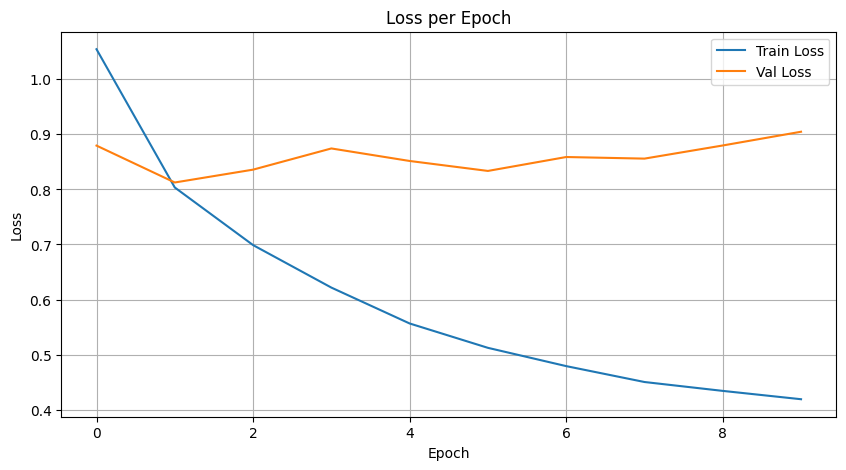

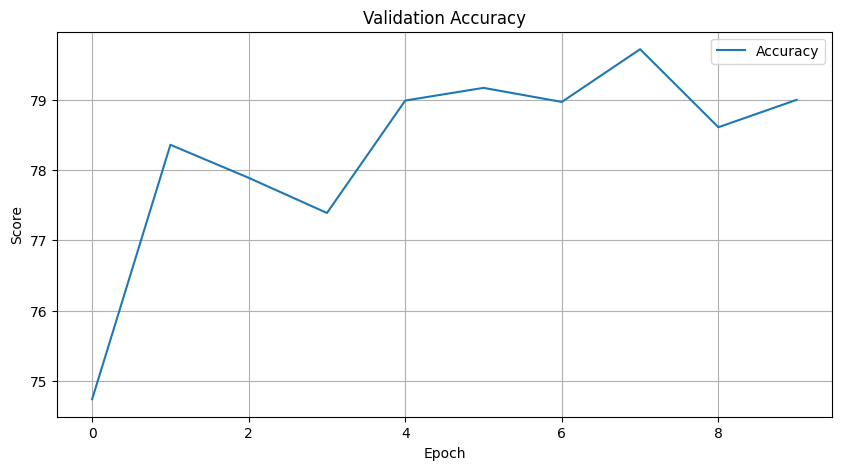

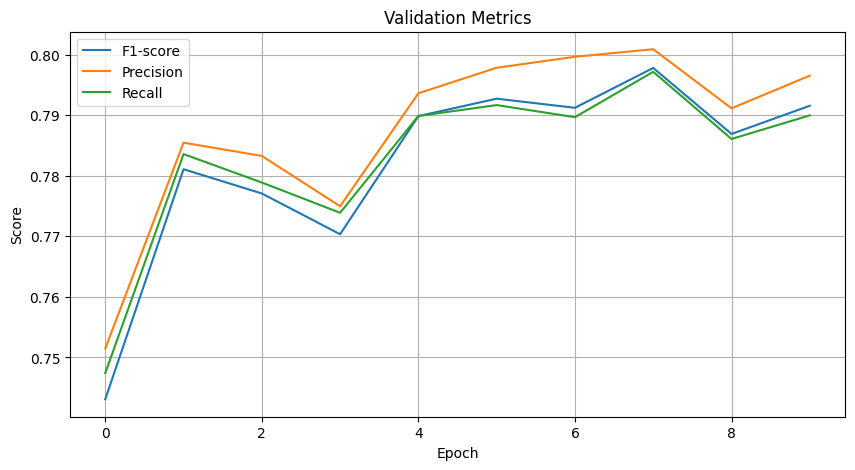

In [208]:
plot_training_history(history_student_distill)

📊 Classification Report:
              precision    recall  f1-score   support

       plane       0.81      0.84      0.82      1000
         car       0.92      0.79      0.85      1000
        bird       0.73      0.70      0.72      1000
         cat       0.58      0.69      0.63      1000
        deer       0.84      0.75      0.79      1000
         dog       0.70      0.70      0.70      1000
        frog       0.78      0.89      0.83      1000
       horse       0.85      0.80      0.83      1000
        ship       0.90      0.88      0.89      1000
       truck       0.86      0.86      0.86      1000

    accuracy                           0.79     10000
   macro avg       0.80      0.79      0.79     10000
weighted avg       0.80      0.79      0.79     10000

🔹 Confusion Matrix:


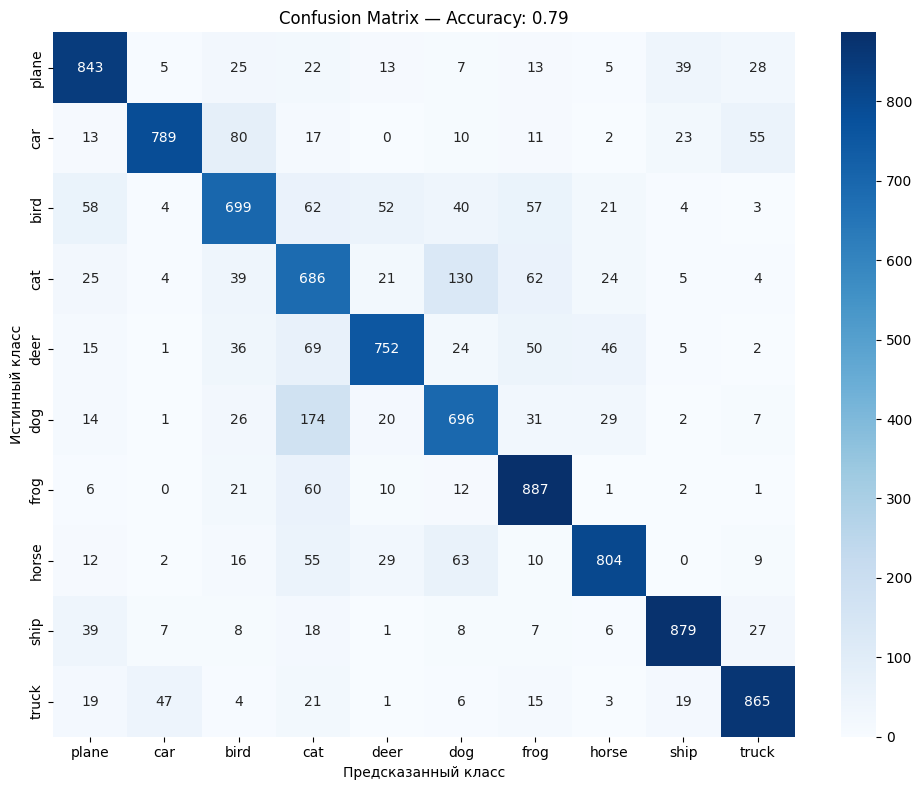

✅ Accuracy: 0.7900


{'accuracy': 0.79,
 'confusion_matrix': array([[843,   5,  25,  22,  13,   7,  13,   5,  39,  28],
        [ 13, 789,  80,  17,   0,  10,  11,   2,  23,  55],
        [ 58,   4, 699,  62,  52,  40,  57,  21,   4,   3],
        [ 25,   4,  39, 686,  21, 130,  62,  24,   5,   4],
        [ 15,   1,  36,  69, 752,  24,  50,  46,   5,   2],
        [ 14,   1,  26, 174,  20, 696,  31,  29,   2,   7],
        [  6,   0,  21,  60,  10,  12, 887,   1,   2,   1],
        [ 12,   2,  16,  55,  29,  63,  10, 804,   0,   9],
        [ 39,   7,   8,  18,   1,   8,   7,   6, 879,  27],
        [ 19,  47,   4,  21,   1,   6,  15,   3,  19, 865]])}

In [209]:
evaluate_metrics(student_model, 
                 test_loader, 
                 device, 
                 classes)

| Класс | Precision | Recall | F1-score | Комментарий                                                                     |
| ----- | --------- | ------ | -------- | ------------------------------------------------------------------------------- |
| plane | 0.81      | 0.84   | 0.82     | Снижение precision, но recall стабильный                                        |
| car   | 0.92      | 0.79   | 0.85     | Очень высокая precision, но низкий recall — модель пропускает часть автомобилей |
| bird  | 0.73      | 0.70   | 0.72     | Средние показатели, трудности с распознаванием птиц                             |
| cat   | 0.58      | 0.69   | 0.63     | Проблемный класс — низкая precision, много ложных срабатываний                  |
| deer  | 0.84      | 0.75   | 0.79     | Хорошая precision, но часть оленей путается с другими животными                 |
| dog   | 0.70      | 0.70   | 0.70     | Средние показатели, трудный класс для Student                                   |
| frog  | 0.78      | 0.89   | 0.83     | Высокий recall, но precision ниже — некоторые ошибки с другими животными        |
| horse | 0.85      | 0.80   | 0.83     | Хорошая классификация лошадей                                                   |
| ship  | 0.90      | 0.88   | 0.89     | Стабильная классификация транспорта                                             |
| truck | 0.86      | 0.86   | 0.86     | Сбалансированные показатели, немного хуже чем car                               |

In [210]:
df_result = pd.concat([df_standard_method, pd.DataFrame([avп_history_student_distill])], ignore_index=True)
df_result

,train_loss,val_loss,val_acc,val_precision,val_recall,val_f1,total_time,model,method
0,0.313,0.619,82.415,0.828,0.824,0.824,169.760,ResNet50,Стандартное обучение
1,0.367,0.816,77.472,0.784,0.775,0.775,78.563,ResNet18,Стандартное обучение
2,0.603,0.859,78.284,0.788,0.783,0.782,121.399,ResNet18,Дистилляция логитов


### **Вывод по эксперименту 1 — Дистилляция логитов**

В первом эксперименте модель-Студент (ResNet18) обучалась не только на истинных метках, но и на «мягких» предсказаниях Учителя (ResNet50).

По итогам видно, что дистилляция логитов дала **незначительный положительный эффект**:

* **Val Accuracy выросла с 77.47% до 78.28%**
* F1-мера улучшилась **с 0.775 до 0.782**
* Рост качества стабилен по всем метрикам (precision/recall/F1).

При этом, что обучение стало дольше (≈121 сек против 78 сек baseline),
Полученный прирост точности подтверждает, что soft logits действительно передают полезную информацию о распределении вероятностей классов, помогая Студенту обучаться более осмысленно, чем при использовании только one-hot меток.

Таким образом, **дистилляция логитов незначительно улучшила качество лёгкой модели**.

### 8. Эксперимент 2 - Учим Студента совпадать по скрытому состоянию с Учителем (без модификации и обучения архитектур)

1. Привести какие-либо блоки скрытого пространства Учителя и Студента к одной размерности.
2. Добавить в целевую функцию ошибки cosine loss между фичами Студента и Учителя.

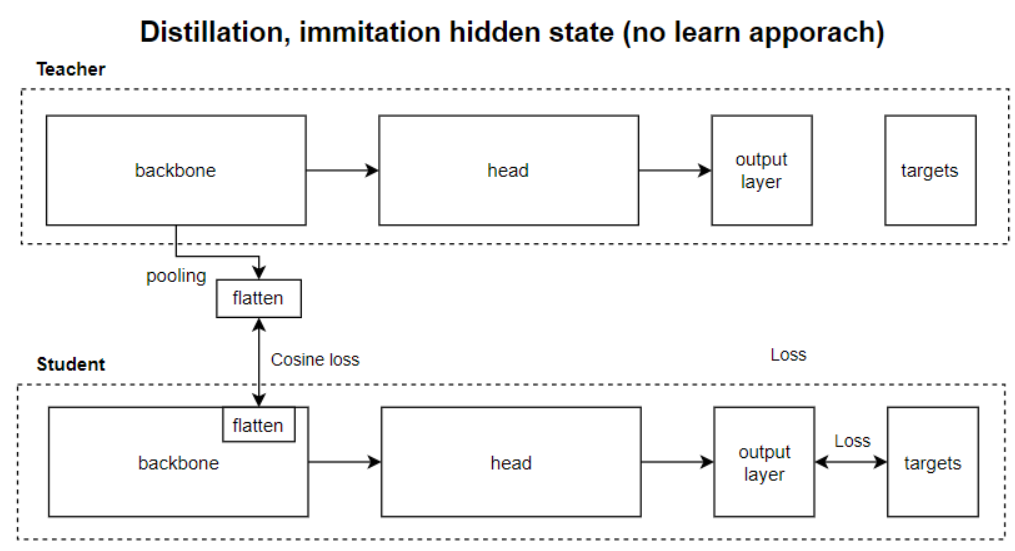

### **Суть метода**

Student принудительно приближает свои внутренние фичи к активациям Teacher через cosine-loss.


**Формула**


Для батча фичей $(F_s)$ (Student) и $(F_t)$ (Teacher), где каждая строка — вектор признаков для одного примера, cosine-loss можно записать как:

$$L_{\text{cos}} = \frac{1}{N}\sum_{i=1}^{N}\bigl(1 - \mathrm{cos_sim}(f_{s}^{(i)}, f_{t}^{(i)})\bigr)$$
где

$$\mathrm{cos_sim}(a,b)=\frac{a\cdot b}{|a||b|}$$

### **Цель**

Передать студенту **структуру признаков**, которую teacher научился извлекать:

* более богатые фичи,
* устойчивые паттерны,
* лучшее представление объектов.

### **Ожидаемое улучшение**

* Улучшение качества классификации студента.

---

#### Ключевые шаги


1. Пропустить вход через Teacher и Student.
2. Извлечь **последние скрытые признаки** *до классификационной головы* (т.е. перед FC).
3. Применить:

   * `AdaptiveAvgPool2d(output_size=(1,1))`
   * `Flatten()`
4. Получить два вектора одинаковой длины.
5. Добавить **cosine loss** между ними.



#### Итог 

1.  **Сначала свернуть фичи Teacher и Student в вектор через pooling + flatten**
2.  **Привести размеры векторов к одному значению (обрезать или падить)**
    У разных моделей скрытые признаки имеют разное число каналов:
    * ResNet-50 (teacher): **2048 канала**
    * ResNet-18 / MobileNet (student): **512 или меньше каналов**
3.  **Добавить cosine loss между этими векторами**
4.  **Teacher обучать нельзя — только Student**
5.  **Teacher идёт в `torch.no_grad()`**

In [211]:
teacher_model = resnet50(weights= None)

# Загружаем веса
state_dict = torch.load('./resnet50_weights/resnet50-11ad3fa6.pth')

teacher_model.load_state_dict(state_dict)

# CIFAR-10 имеет 10 классов, поэтому нужно адаптировать последний слой сети
# (ResNet50 по умолчанию рассчитан на 1000 классов ImageNet.)
teacher_model.fc = nn.Linear(2048, 10)

In [212]:
student_model = resnet18(weights=None)

# Загружаем веса
state_dict = torch.load('./resnet18_weights/resnet18-f37072fd.pth')

student_model.load_state_dict(state_dict)

student_model.fc = nn.Linear(512, 10)

In [213]:
LEARNING_RATE = 0.001

teacher_optimizer = optim.AdamW(teacher_model.parameters(), 
                                lr=LEARNING_RATE)

student_optimizer = optim.AdamW(student_model.parameters(), 
                                lr=LEARNING_RATE)

In [214]:
EPOCHS = 10

In [215]:
def extract_hidden(model, x):
    # получаем фичи перед FC слоем
    features = model.avgpool(model.layer4(model.layer3(model.layer2(model.layer1(model.relu(model.bn1(model.conv1(x))))))))
    
    # spatial shape → (1,1)
    features = F.adaptive_avg_pool2d(features, (1,1))

    # flatten → вектор
    features = torch.flatten(features, 1)

    return features

In [216]:
def cosine_distillation_loss(student_feats, teacher_feats):
    
    # приведение к одинаковой длине (укоротим teacher)
    min_dim = min(student_feats.shape[1], teacher_feats.shape[1])
    
    student_feats = student_feats[:, :min_dim]
    teacher_feats = teacher_feats[:, :min_dim]

    # косинусная дистанция
    cos_sim = F.cosine_similarity(student_feats, teacher_feats, dim=1)
    return (1 - cos_sim).mean()   # хотим max similarity → min loss

In [217]:
def train_distill_cosine(
                            teacher_model,
                            student_model,
                            device,
                            train_loader,
                            val_loader,
                            optimizer,
                            num_epochs=10,
                            alpha=0.3,
                            writer=None
                        ):
    """
        Эксперимент 2:
    - Teacher заморожен
    - Student обучается
    - Дистилляция через cosine embedding на скрытых признаках.
    """

    teacher_model.to(device)
    student_model.to(device)
    teacher_model.eval()  # учитель не обучается

    history = {
        "train_loss": [],
        "val_loss": [],
        "val_acc": [],
        "val_precision": [],
        "val_recall": [],
        "val_f1": [],
        "total_time": 0
    }

    total_start = time.time()

    for epoch in range(num_epochs):

        # ---------- ОБУЧЕНИЕ ----------
        student_model.train()
        running_loss = 0.0

        train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] (train)", leave=False)

        for inputs, targets in train_loop:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            # student
            student_outputs = student_model(inputs)
            student_feats = extract_hidden(student_model, inputs)

            # teacher
            with torch.no_grad():
                teacher_outputs = teacher_model(inputs)
                teacher_feats = extract_hidden(teacher_model, inputs)

            # CE loss
            loss_ce = F.cross_entropy(student_outputs, targets)

            # cosine distillation loss
            loss_cos = cosine_distillation_loss(student_feats, teacher_feats)

            # итоговая ошибка
            loss = (1 - alpha) * loss_ce + alpha * loss_cos

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_loop.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)

        # ---------- ВАЛИДАЦИЯ ----------
        student_model.eval()
        val_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] (val)", leave=False)

            for inputs, targets in val_loop:
                inputs, targets = inputs.to(device), targets.to(device)

                student_outputs = student_model(inputs)
                teacher_outputs = teacher_model(inputs)

                # признаки
                student_feats = extract_hidden(student_model, inputs)
                teacher_feats = extract_hidden(teacher_model, inputs)

                loss_ce = F.cross_entropy(student_outputs, targets)
                loss_cos = cosine_distillation_loss(student_feats, teacher_feats)
                loss = (1 - alpha) * loss_ce + alpha * loss_cos

                val_loss += loss.item()

                # метрики
                _, predicted = torch.max(student_outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(targets.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
        val_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        val_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)

        # ---------- ЛОГИРОВАНИЕ В TENSORBOARD ----------
        if writer is not None:
            writer.add_scalar("Loss/Train", avg_train_loss, epoch)
            writer.add_scalar("Loss/Val", avg_val_loss, epoch)
            writer.add_scalar("Accuracy/Val", val_accuracy, epoch)
            writer.add_scalar("Precision/Val", val_precision, epoch)
            writer.add_scalar("Recall/Val", val_recall, epoch)
            writer.add_scalar("F1/Val", val_f1, epoch)

            if epoch % 5 == 0:
                imgs_grid = torchvision.utils.make_grid(inputs[:8].cpu(), normalize=True)
                writer.add_image("Sample Images", imgs_grid, epoch)

        # ---------- ИСТОРИЯ ----------
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {avg_train_loss:.4f} | "
            f"Val Loss: {avg_val_loss:.4f} | "
            f"Val Acc: {val_accuracy:.2f}% | "
            f"Val Precision: {val_precision:.2f}% | "
            f"Val Recall: {val_recall:.2f}% | "
            f"Val F1: {val_f1:.3f}"
        )

    total_time = time.time() - total_start
    history["total_time"] = total_time

    print(f"\nДистилляция (cosine) завершена за {total_time/60:.2f} мин ({total_time:.1f} сек)")

    if writer is not None:
        writer.close()

    return history

In [218]:
history_student_cosine = train_distill_cosine(
                                                teacher_model=teacher_model,
                                                student_model=student_model,
                                                device=device,
                                                train_loader=train_loader,
                                                val_loader=test_loader,
                                                optimizer=student_optimizer,
                                                num_epochs=EPOCHS,
                                                alpha=0.1,
                                                writer=writer
                                            )

Epoch [1/10] Train Loss: 0.9199 | Val Loss: 1.4123 | Val Acc: 67.11% | Val Precision: 0.70% | Val Recall: 0.67% | Val F1: 0.654


Epoch [2/10] Train Loss: 0.6088 | Val Loss: 1.1710 | Val Acc: 72.03% | Val Precision: 0.75% | Val Recall: 0.72% | Val F1: 0.711


Epoch [3/10] Train Loss: 0.4640 | Val Loss: 0.9597 | Val Acc: 71.79% | Val Precision: 0.75% | Val Recall: 0.72% | Val F1: 0.709


Epoch [4/10] Train Loss: 0.3749 | Val Loss: 0.8393 | Val Acc: 73.70% | Val Precision: 0.75% | Val Recall: 0.74% | Val F1: 0.730


Epoch [5/10] Train Loss: 0.3000 | Val Loss: 0.7906 | Val Acc: 73.40% | Val Precision: 0.75% | Val Recall: 0.73% | Val F1: 0.727


Epoch [6/10] Train Loss: 0.2398 | Val Loss: 0.6993 | Val Acc: 76.36% | Val Precision: 0.77% | Val Recall: 0.76% | Val F1: 0.759


Epoch [7/10] Train Loss: 0.2101 | Val Loss: 0.7569 | Val Acc: 74.36% | Val Precision: 0.76% | Val Recall: 0.74% | Val F1: 0.737


Epoch [8/10] Train Loss: 0.1700 | Val Loss: 0.7320 | Val Acc: 75.92% | Val Precision: 0.77% | Val Recall: 0.76% | Val F1: 0.752


Epoch [9/10] Train Loss: 0.1465 | Val Loss: 0.7360 | Val Acc: 76.32% | Val Precision: 0.78% | Val Recall: 0.76% | Val F1: 0.760


Epoch [10/10] Train Loss: 0.1250 | Val Loss: 0.7630 | Val Acc: 76.73% | Val Precision: 0.78% | Val Recall: 0.77% | Val F1: 0.765

Дистилляция (cosine) завершена за 3.51 мин (210.5 сек)


In [224]:
history_student_cosine

{'train_loss': [0.9198756130683757,
  0.6087766175379838,
  0.46395969463278874,
  0.3749072819833865,
  0.30004799821416434,
  0.23981127646916053,
  0.21012584832699402,
  0.17004496210714434,
  0.14651955224459282,
  0.12500453963065924],
 'val_loss': [1.4122755314893782,
  1.1709926473866603,
  0.959674985545456,
  0.8392501606303415,
  0.7905524183230795,
  0.6993344130030104,
  0.7569237237523316,
  0.7319967965031885,
  0.7360452564468809,
  0.7630311230755156],
 'val_acc': [np.float64(67.11),
  np.float64(72.03),
  np.float64(71.78999999999999),
  np.float64(73.7),
  np.float64(73.4),
  np.float64(76.36),
  np.float64(74.36),
  np.float64(75.92),
  np.float64(76.32),
  np.float64(76.73)],
 'val_precision': [np.float64(0.7041441365477705),
  np.float64(0.7547797603386334),
  np.float64(0.7484760707685674),
  np.float64(0.7529324422485677),
  np.float64(0.754548617270448),
  np.float64(0.7708803224294595),
  np.float64(0.7593001855581745),
  np.float64(0.7735610321839437),
  np.f

In [225]:
avg_history_student_distill_cosine = summarize_history(history_student_cosine, 
                                                       model_name="ResNet18", 
                                                       method = 'Дистилляция по скрытому состоянию')
avg_history_student_distill_cosine

{'train_loss': np.float64(0.356),
 'val_loss': np.float64(0.886),
 'val_acc': np.float64(73.772),
 'val_precision': np.float64(0.757),
 'val_recall': np.float64(0.738),
 'val_f1': np.float64(0.73),
 'total_time': 210.507,
 'model': 'ResNet18',
 'method': 'Дистилляция по скрытому состоянию'}

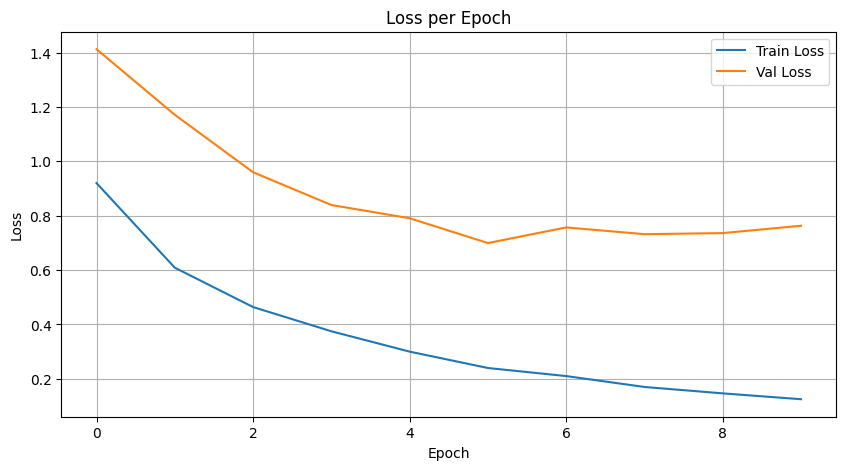

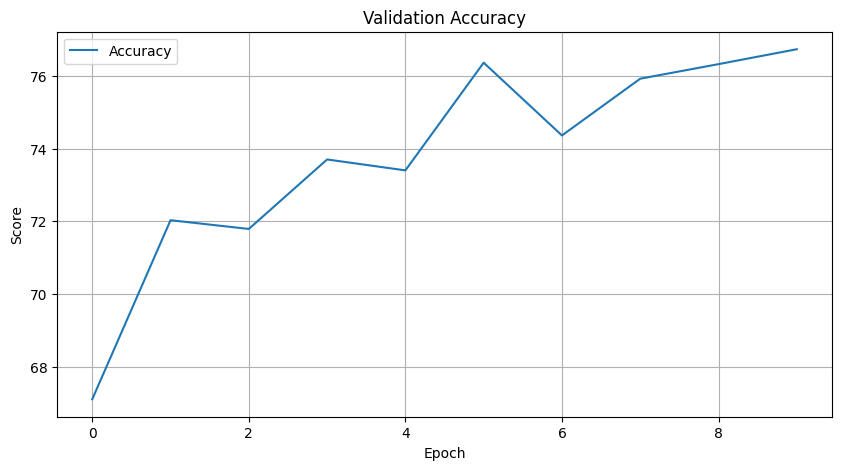

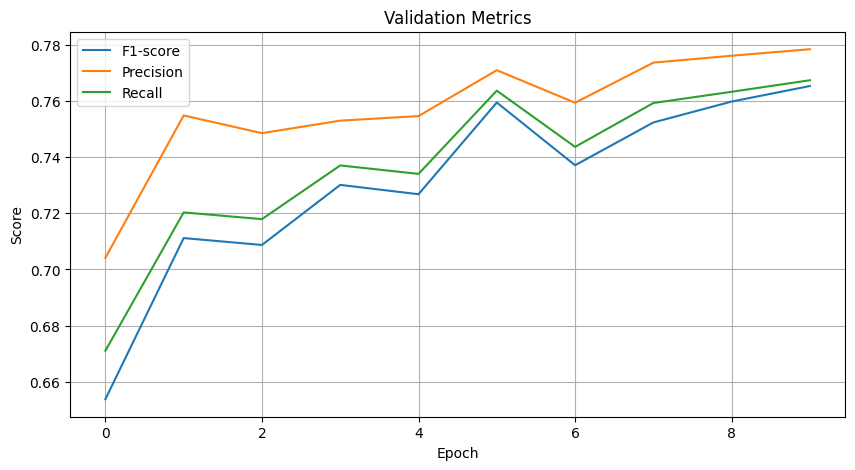

In [226]:
plot_training_history(history_student_cosine)

📊 Classification Report:
              precision    recall  f1-score   support

       plane       0.82      0.80      0.81      1000
         car       0.87      0.86      0.86      1000
        bird       0.81      0.65      0.72      1000
         cat       0.66      0.55      0.60      1000
        deer       0.84      0.60      0.70      1000
         dog       0.70      0.70      0.70      1000
        frog       0.61      0.94      0.74      1000
       horse       0.80      0.84      0.82      1000
        ship       0.92      0.84      0.87      1000
       truck       0.78      0.90      0.83      1000

    accuracy                           0.77     10000
   macro avg       0.78      0.77      0.77     10000
weighted avg       0.78      0.77      0.77     10000

🔹 Confusion Matrix:


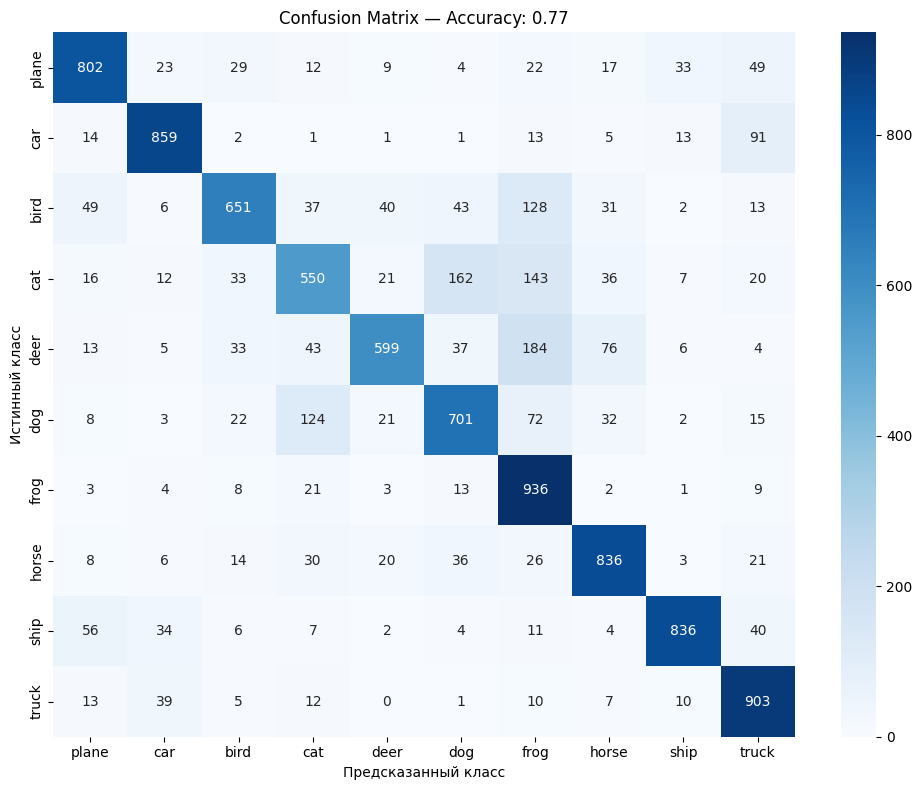

✅ Accuracy: 0.7673


{'accuracy': 0.7673,
 'confusion_matrix': array([[802,  23,  29,  12,   9,   4,  22,  17,  33,  49],
        [ 14, 859,   2,   1,   1,   1,  13,   5,  13,  91],
        [ 49,   6, 651,  37,  40,  43, 128,  31,   2,  13],
        [ 16,  12,  33, 550,  21, 162, 143,  36,   7,  20],
        [ 13,   5,  33,  43, 599,  37, 184,  76,   6,   4],
        [  8,   3,  22, 124,  21, 701,  72,  32,   2,  15],
        [  3,   4,   8,  21,   3,  13, 936,   2,   1,   9],
        [  8,   6,  14,  30,  20,  36,  26, 836,   3,  21],
        [ 56,  34,   6,   7,   2,   4,  11,   4, 836,  40],
        [ 13,  39,   5,  12,   0,   1,  10,   7,  10, 903]])}

In [227]:
evaluate_metrics(student_model, 
                 test_loader, 
                 device, 
                 classes)

| Класс | Precision | Recall | F1-score | Комментарий                                                                                    |
| ----- | --------- | ------ | -------- | ---------------------------------------------------------------------------------------------- |
| plane | 0.82      | 0.80   | 0.81     | Хорошая, но небольшое снижение recall — часть самолетов путается с другими классами транспорта |
| car   | 0.87      | 0.86   | 0.86     | Стабильная классификация автомобилей                                                           |
| bird  | 0.81      | 0.65   | 0.72     | Значительное снижение recall — птицы часто пропускаются, путаница с животными                  |
| cat   | 0.66      | 0.55   | 0.60     | Слабый класс — низкая precision и recall, кошки путаются с собаками и другими животными        |
| deer  | 0.84      | 0.60   | 0.70     | Сильное падение recall — часть оленей классифицируется неправильно                             |
| dog   | 0.70      | 0.70   | 0.70     | Средние показатели — трудный класс, ошибки с кошками и другими животными                       |
| frog  | 0.61      | 0.94   | 0.74     | Высокий recall, но низкая precision — много ложноположительных срабатываний на другие классы   |
| horse | 0.80      | 0.84   | 0.82     | Хорошие показатели, модель различает лошадей достаточно верно                                  |
| ship  | 0.92      | 0.84   | 0.87     | Отличная precision, небольшое падение recall — часть кораблей путается с самолетами            |
| truck | 0.78      | 0.90   | 0.83     | Хороший recall, но ниже precision — грузовики иногда путают с автомобилями                     |

In [223]:
df_result = pd.concat([df_result, 
                       pd.DataFrame([avg_history_student_distill_cosine])], 
                       ignore_index=True)
df_result

,train_loss,val_loss,val_acc,val_precision,val_recall,val_f1,total_time,model,method
0,0.313,0.619,82.415,0.828,0.824,0.824,169.760,ResNet50,Стандартное обучение
1,0.367,0.816,77.472,0.784,0.775,0.775,78.563,ResNet18,Стандартное обучение
2,0.603,0.859,78.284,0.788,0.783,0.782,121.399,ResNet18,Дистилляция логитов
3,0.356,0.886,73.772,0.757,0.738,0.730,210.507,ResNet18,Дистилляция по скрытому состоянию


In [228]:
df_result.to_csv('./results.csv')

### **Вывод по эксперименту 2 — Дистилляция по скрытому состоянию (feature/cosine loss)**

В этом эксперименте Студент обучался приближать свои скрытые фичи к фичам Учителя через **cosine loss**, без изменения архитектуры.

Результаты показали, что точность модели **упала до 73.77%**, что ниже baseline ResNet18 (77.47%). F1-мера также снизилась (≈0.73).

---

### **Возможные причины низкого качества**

1. **Несовместимость скрытых признаков Teacher и Student**

   * Teacher (ResNet50) и Student (ResNet18) имеют разную глубину и структуру блоков.
   * Фичи из разных моделей могут иметь разное семантическое значение, даже при одинаковых размерностях.

2. **Конфликт градиентов**

   * Cosine loss заставляет Student подстраиваться под направления Teacher-фич, что может мешать оптимизации CE loss на истинных метках.

3. **Вес косинусной ошибки alpha слишком велик, Student теряет способность учиться собственным признакам для классификации.**

---

### **Варианты улучшения**

* Применить **обучаемый линейный/conv1x1 проекционный слой** для согласования фич Teacher и Student.
* Уменьшить **вес cosine loss** относительно CE loss (alpha < 0.5), чтобы сохранить обучение на истинных метках.
* Использовать **intermediate-layer distillation** (несколько промежуточных уровней, а не только последний блок).
* Попробовать **feature transformation/normalization**, чтобы выровнять распределения фич.

### 9. Эксперимент 3 - Добавляем обучаемый регрессор

1. Добавить в архитектуру новый блок, который может обучаться (conv2d).
2. Добавить в целевую функцию ошибки MSE loss между фичами Студента и Учителя.

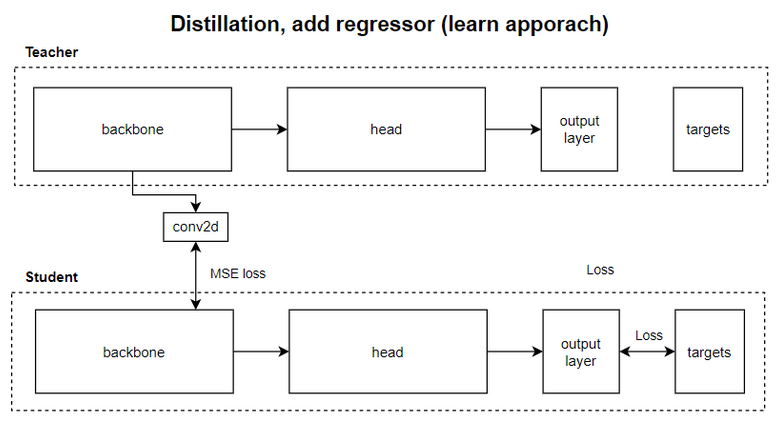


```
Teacher Backbone → Pooling → Flatten → FEATURE_T
                                       │
                                   Conv2d (регрессор)
                                       │
                                                   +→ MSE Loss
Student Backbone → Pooling → Flatten → FEATURE_S ──┘
```

### **Суть метода**

Между teacher-фичами и student-фичами добавляется обучаемый conv2d-регрессор:


$$g_\theta(f_{teacher}) \approx f_{student}$$

Регрессор обучается совместно со student.

### **Цель**

Подогнать teacher-фичи под формат student-фич:

* выровнять каналы,
* адаптировать распределение признаков,
* снизить несовместимость архитектур Teacher и Student.

### **Ожидаемое улучшение**

* повышение качества Студента.

---

In [237]:
teacher_model = resnet50(weights= None)

# Загружаем веса
state_dict = torch.load('./resnet50_weights/resnet50-11ad3fa6.pth')

teacher_model.load_state_dict(state_dict)

# CIFAR-10 имеет 10 классов, поэтому нужно адаптировать последний слой сети
# (ResNet50 по умолчанию рассчитан на 1000 классов ImageNet.)
teacher_model.fc = nn.Linear(2048, 10)

In [238]:
student_model = resnet18(weights=None)

# Загружаем веса
state_dict = torch.load('./resnet18_weights/resnet18-f37072fd.pth')

student_model.load_state_dict(state_dict)

student_model.fc = nn.Linear(512, 10)

Извлечение фичей (Teacher & Student)

Берём фичи до классификационной головы:

In [239]:
def extract_features(model, x):
    # Feature maps
    x = model.relu(model.bn1(model.conv1(x)))
    x = model.layer1(x)
    x = model.layer2(x)
    x = model.layer3(x)
    x = model.layer4(x)

    # Pooling
    x = F.adaptive_avg_pool2d(x, (1, 1))

    return x  # [B, C, 1, 1]

Добавляем обучаемый Conv2d-регрессор

In [240]:
class FeatureRegressor(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.regressor = nn.Conv2d(
                                    in_channels=in_channels,
                                    out_channels=out_channels,
                                    kernel_size=1
                                )

    def forward(self, x):
        return self.regressor(x)


In [241]:
regressor = FeatureRegressor(in_channels=2048, out_channels=512).to(device)

In [242]:
LEARNING_RATE = 0.001

In [243]:
optimizer = torch.optim.AdamW(
                                list(student_model.parameters()) + list(regressor.parameters()),
                                lr=LEARNING_RATE
                            )

alpha = 0.4  # вес MSE дистилляции

In [244]:
def train_distill_regressor(
                            teacher_model,
                            student_model,
                            regressor,
                            device,
                            train_loader,
                            val_loader,
                            optimizer,
                            num_epochs=10,
                            alpha=0.4,
                            writer=None
                        ):
    """
    Эксперимент 3:
    - Teacher заморожен
    - Student обучается
    - Между Teacher Features и Student Features — обучаемый Conv2D регрессор
    - Итоговый лосс = CE + alpha * MSE(feature_teacher_proj, feature_student)
    """

    teacher_model.to(device)
    student_model.to(device)
    regressor.to(device)

    teacher_model.eval()   # teacher НЕ обучается

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_acc': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': [],
        'total_time': 0
    }

    total_start = time.time()

    # ---------- ОБУЧЕНИЕ ----------
    for epoch in range(num_epochs):

        student_model.train()
        regressor.train()

        running_loss = 0.0
        train_loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] (train)", leave=False)

        for inputs, targets in train_loop:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()

            # ----- Учитель-----
            with torch.no_grad():
                teacher_features = extract_features(teacher_model, inputs)

            # коректировка размерностей teacher → student shape
            teacher_proj = regressor(teacher_features)

            # ----- Студент -----
            student_outputs = student_model(inputs)
            student_features = extract_features(student_model, inputs)

            # CE loss
            ce_loss = F.cross_entropy(student_outputs, targets)

            # Feature MSE
            mse_loss = F.mse_loss(teacher_proj, student_features)

            # Total loss
            loss = ce_loss + alpha * mse_loss
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            
            train_loop.set_postfix(loss=loss.item())

        avg_train_loss = running_loss / len(train_loader)

        # ---------- ВАЛИДАЦИЯ ----------
        student_model.eval()
        regressor.eval()

        val_loss = 0.0
        all_preds, all_labels = [], []

        with torch.no_grad():
            val_loop = tqdm(val_loader, desc=f"Epoch [{epoch+1}/{num_epochs}] (val)", leave=False)

            for inputs, targets in val_loop:
                inputs, targets = inputs.to(device), targets.to(device)

                teacher_features = extract_features(teacher_model, inputs)
                teacher_proj = regressor(teacher_features)

                student_outputs = student_model(inputs)
                student_features = extract_features(student_model, inputs)

                ce_loss = F.cross_entropy(student_outputs, targets)
                mse_loss = F.mse_loss(teacher_proj, student_features)

                loss = ce_loss + alpha * mse_loss
                val_loss += loss.item()

                _, predicted = torch.max(student_outputs, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(targets.cpu().numpy())

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * np.mean(np.array(all_preds) == np.array(all_labels))
        val_precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
        val_recall    = recall_score(all_labels, all_preds, average="macro", zero_division=0)
        val_f1        = f1_score(all_labels, all_preds, average="macro", zero_division=0)

        # ---------- ЛОГИРОВАНИЕ В TENSORBOARD ----------
        if writer is not None:
            writer.add_scalar("Loss/Train", avg_train_loss, epoch)
            writer.add_scalar("Loss/Val", avg_val_loss, epoch)
            writer.add_scalar("Accuracy/Val", val_accuracy, epoch)
            writer.add_scalar("Precision/Val", val_precision, epoch)
            writer.add_scalar("Recall/Val", val_recall, epoch)
            writer.add_scalar("F1/Val", val_f1, epoch)

            if epoch % 5 == 0:
                img_grid = torchvision.utils.make_grid(inputs[:8].cpu(), normalize=True)
                writer.add_image("Validation/Images", img_grid, epoch)

        # ---------- ИСТОРИЯ ----------        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_acc'].append(val_accuracy)
        history['val_precision'].append(val_precision)
        history['val_recall'].append(val_recall)
        history['val_f1'].append(val_f1)

        print(
            f"Epoch [{epoch+1}/{num_epochs}] "
            f"Train Loss: {avg_train_loss:.4f} | "
            f"Val Loss: {avg_val_loss:.4f} | "
            f"Val Acc: {val_accuracy:.2f}% | "
            f"Val Precision: {val_precision:.2f}% | "
            f"Val Recall: {val_recall:.2f}% | "
            f"Val F1: {val_f1:.3f}"
        )

    total_time = time.time() - total_start
    history['total_time'] = total_time

    print(f"\nДистилляция (regressor) завершена за {total_time/60:.2f} мин ({total_time:.1f} сек)")

    if writer is not None:
        writer.close()

    return history

In [245]:
history_ditill_regressor = train_distill_regressor(
                                                    teacher_model=teacher_model,
                                                    student_model=student_model,
                                                    regressor=regressor,
                                                    device=device,
                                                    train_loader=train_loader,
                                                    val_loader=test_loader,
                                                    optimizer=optimizer,
                                                    num_epochs=EPOCHS,
                                                    alpha=0.1,
                                                    writer=writer
                                                )

Epoch [1/10] Train Loss: 0.9680 | Val Loss: 1.2941 | Val Acc: 67.50% | Val Precision: 0.71% | Val Recall: 0.68% | Val F1: 0.663


Epoch [2/10] Train Loss: 0.6356 | Val Loss: 1.0599 | Val Acc: 69.85% | Val Precision: 0.74% | Val Recall: 0.70% | Val F1: 0.696


Epoch [3/10] Train Loss: 0.4976 | Val Loss: 0.8914 | Val Acc: 72.64% | Val Precision: 0.75% | Val Recall: 0.73% | Val F1: 0.722


Epoch [4/10] Train Loss: 0.3796 | Val Loss: 0.8093 | Val Acc: 74.18% | Val Precision: 0.76% | Val Recall: 0.74% | Val F1: 0.741


Epoch [5/10] Train Loss: 0.3016 | Val Loss: 0.7968 | Val Acc: 73.93% | Val Precision: 0.75% | Val Recall: 0.74% | Val F1: 0.735


Epoch [6/10] Train Loss: 0.2357 | Val Loss: 0.8280 | Val Acc: 74.70% | Val Precision: 0.76% | Val Recall: 0.75% | Val F1: 0.744


Epoch [7/10] Train Loss: 0.2018 | Val Loss: 0.8729 | Val Acc: 74.75% | Val Precision: 0.76% | Val Recall: 0.75% | Val F1: 0.743


Epoch [8/10] Train Loss: 0.1795 | Val Loss: 0.8443 | Val Acc: 76.38% | Val Precision: 0.77% | Val Recall: 0.76% | Val F1: 0.759


Epoch [9/10] Train Loss: 0.1237 | Val Loss: 0.8377 | Val Acc: 77.69% | Val Precision: 0.78% | Val Recall: 0.78% | Val F1: 0.773


Epoch [10/10] Train Loss: 0.1044 | Val Loss: 1.0844 | Val Acc: 74.20% | Val Precision: 0.76% | Val Recall: 0.74% | Val F1: 0.735

Дистилляция (regressor) завершена за 2.78 мин (167.0 сек)


In [246]:
history_ditill_regressor

{'train_loss': [0.9680014585747438,
  0.635645123775048,
  0.4976421168355076,
  0.37958976706427994,
  0.3016217803139516,
  0.23574973546120975,
  0.20181598893040434,
  0.17945182666687481,
  0.12370890127899854,
  0.10443144205771863],
 'val_loss': [1.2940787669200047,
  1.0599208584256992,
  0.8913647156612129,
  0.8092569729704766,
  0.7968263903241248,
  0.827968777364986,
  0.8728642204574718,
  0.8442516296532503,
  0.8377170357734535,
  1.084444006727],
 'val_acc': [np.float64(67.5),
  np.float64(69.85),
  np.float64(72.64),
  np.float64(74.18),
  np.float64(73.92999999999999),
  np.float64(74.7),
  np.float64(74.75),
  np.float64(76.38000000000001),
  np.float64(77.69),
  np.float64(74.2)],
 'val_precision': [np.float64(0.7108904008675522),
  np.float64(0.7364704485487243),
  np.float64(0.7529492141041129),
  np.float64(0.7566069433099838),
  np.float64(0.7503444411968356),
  np.float64(0.7637457273884738),
  np.float64(0.7608872799150747),
  np.float64(0.7747653895668909),


In [249]:
avg_history_student_distill_regressor = summarize_history(history_ditill_regressor, 
                                                       model_name="ResNet18", 
                                                       method = 'Дистилляция с регрессором')
avg_history_student_distill_regressor

{'train_loss': np.float64(0.363),
 'val_loss': np.float64(0.932),
 'val_acc': np.float64(73.582),
 'val_precision': np.float64(0.754),
 'val_recall': np.float64(0.736),
 'val_f1': np.float64(0.731),
 'total_time': 166.963,
 'model': 'ResNet18',
 'method': 'Дистилляция с регрессором'}

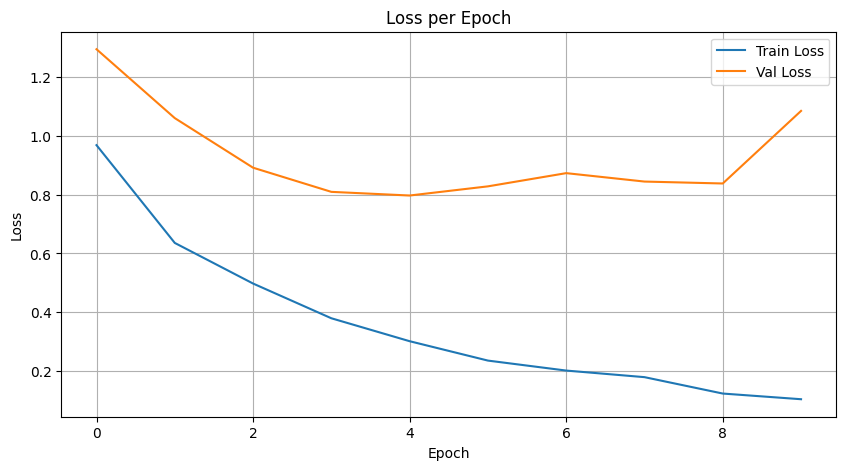

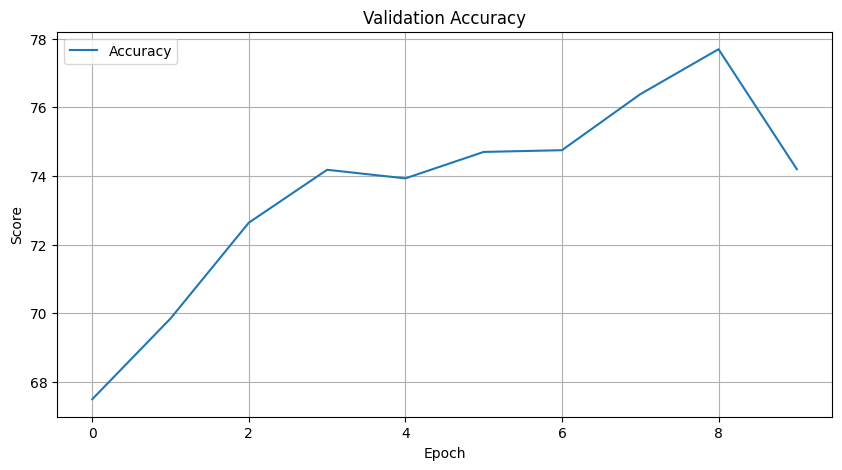

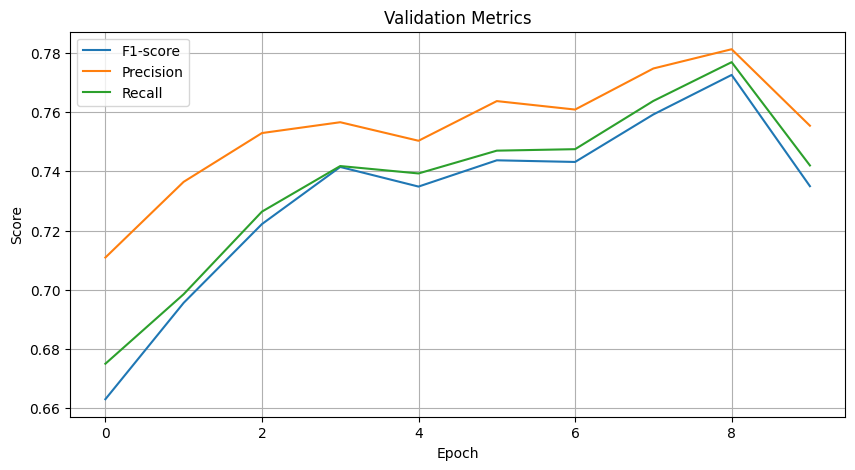

In [250]:
plot_training_history(history_ditill_regressor)

📊 Classification Report:
              precision    recall  f1-score   support

       plane       0.66      0.87      0.75      1000
         car       0.67      0.96      0.79      1000
        bird       0.76      0.69      0.72      1000
         cat       0.66      0.48      0.55      1000
        deer       0.91      0.52      0.66      1000
         dog       0.75      0.57      0.65      1000
        frog       0.69      0.88      0.77      1000
       horse       0.76      0.84      0.80      1000
        ship       0.88      0.84      0.86      1000
       truck       0.83      0.76      0.79      1000

    accuracy                           0.74     10000
   macro avg       0.76      0.74      0.73     10000
weighted avg       0.76      0.74      0.73     10000

🔹 Confusion Matrix:


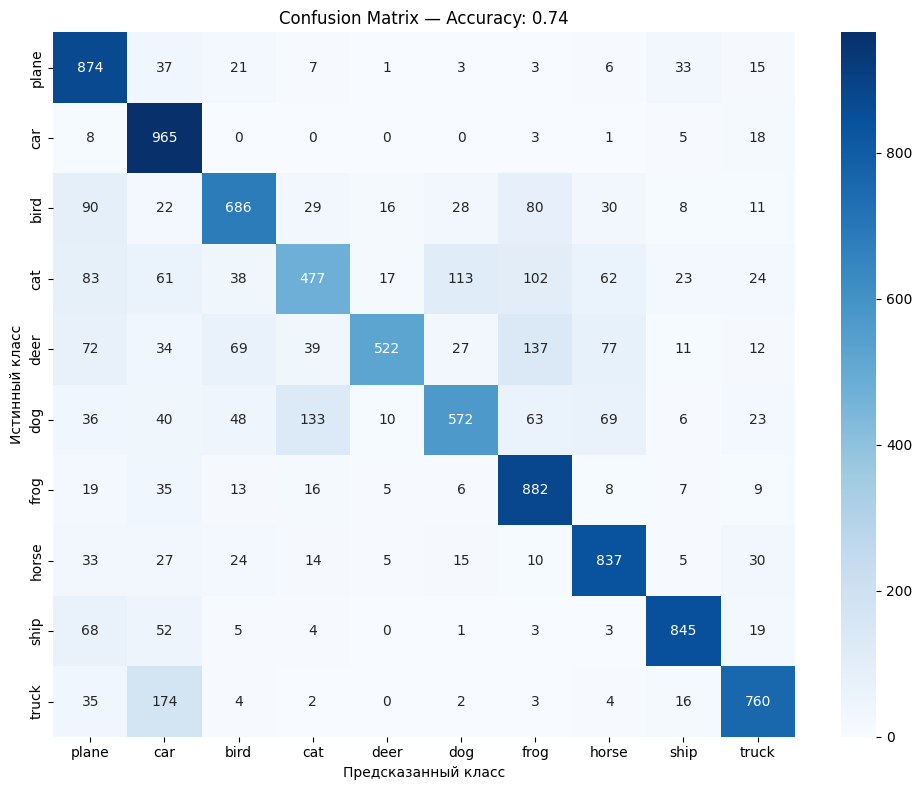

✅ Accuracy: 0.7420


{'accuracy': 0.742,
 'confusion_matrix': array([[874,  37,  21,   7,   1,   3,   3,   6,  33,  15],
        [  8, 965,   0,   0,   0,   0,   3,   1,   5,  18],
        [ 90,  22, 686,  29,  16,  28,  80,  30,   8,  11],
        [ 83,  61,  38, 477,  17, 113, 102,  62,  23,  24],
        [ 72,  34,  69,  39, 522,  27, 137,  77,  11,  12],
        [ 36,  40,  48, 133,  10, 572,  63,  69,   6,  23],
        [ 19,  35,  13,  16,   5,   6, 882,   8,   7,   9],
        [ 33,  27,  24,  14,   5,  15,  10, 837,   5,  30],
        [ 68,  52,   5,   4,   0,   1,   3,   3, 845,  19],
        [ 35, 174,   4,   2,   0,   2,   3,   4,  16, 760]])}

In [251]:
evaluate_metrics(student_model, 
                 test_loader, 
                 device, 
                 classes)

| Класс | Precision | Recall | F1-score | Комментарий                                                                              |
| ----- | --------- | ------ | -------- | ---------------------------------------------------------------------------------------- |
| plane | 0.66      | 0.87   | 0.75     | Высокий recall, но низкая precision — модель часто путает самолёты с другими объектами   |
| car   | 0.67      | 0.96   | 0.79     | Отличный recall, но низкая precision — много ложноположительных срабатываний             |
| bird  | 0.76      | 0.69   | 0.72     | Средние показатели — часть птиц пропускается, часть классифицируется неверно             |
| cat   | 0.66      | 0.48   | 0.55     | Очень слабый класс — низкий recall и precision, кошки часто путаются с другими животными |
| deer  | 0.91      | 0.52   | 0.66     | Высокая precision, но половина оленей классифицируется неправильно (низкий recall)       |
| dog   | 0.75      | 0.57   | 0.65     | Трудный класс — многие собаки неправильно классифицируются                               |
| frog  | 0.69      | 0.88   | 0.77     | Хороший recall, но precision умеренная — частые ложноположительные срабатывания          |
| horse | 0.76      | 0.84   | 0.80     | Достаточно стабильный класс, F1 = 0.80                                                   |
| ship  | 0.88      | 0.84   | 0.86     | Хорошие показатели для транспортного класса                                              |
| truck | 0.83      | 0.76   | 0.79     | Умеренные показатели — точность немного выше, recall ниже                                |

In [252]:
df_result = pd.concat([df_result, 
                       pd.DataFrame([avg_history_student_distill_regressor])], 
                       ignore_index=True)
df_result

,train_loss,val_loss,val_acc,val_precision,val_recall,val_f1,total_time,model,method
0,0.313,0.619,82.415,0.828,0.824,0.824,169.760,ResNet50,Стандартное обучение
1,0.367,0.816,77.472,0.784,0.775,0.775,78.563,ResNet18,Стандартное обучение
2,0.603,0.859,78.284,0.788,0.783,0.782,121.399,ResNet18,Дистилляция логитов
3,0.356,0.886,73.772,0.757,0.738,0.730,210.507,ResNet18,Дистилляция по скрытому состоянию
4,0.363,0.932,73.582,0.754,0.736,0.731,166.963,ResNet18,Дистилляция с регрессором


In [253]:
df_result.to_csv('./results.csv')

In [254]:
df_result.to_dict(orient = 'records')

[{'train_loss': 0.313,
  'val_loss': 0.619,
  'val_acc': 82.415,
  'val_precision': 0.828,
  'val_recall': 0.824,
  'val_f1': 0.824,
  'total_time': 169.76,
  'model': 'ResNet50',
  'method': 'Стандартное обучение'},
 {'train_loss': 0.367,
  'val_loss': 0.816,
  'val_acc': 77.472,
  'val_precision': 0.784,
  'val_recall': 0.775,
  'val_f1': 0.775,
  'total_time': 78.563,
  'model': 'ResNet18',
  'method': 'Стандартное обучение'},
 {'train_loss': 0.603,
  'val_loss': 0.859,
  'val_acc': 78.284,
  'val_precision': 0.788,
  'val_recall': 0.783,
  'val_f1': 0.782,
  'total_time': 121.399,
  'model': 'ResNet18',
  'method': 'Дистилляция логитов'},
 {'train_loss': 0.356,
  'val_loss': 0.886,
  'val_acc': 73.772,
  'val_precision': 0.757,
  'val_recall': 0.738,
  'val_f1': 0.73,
  'total_time': 210.507,
  'model': 'ResNet18',
  'method': 'Дистилляция по скрытому состоянию'},
 {'train_loss': 0.363,
  'val_loss': 0.932,
  'val_acc': 73.582,
  'val_precision': 0.754,
  'val_recall': 0.736,
  'va

### **Вывод по эксперименту 3 — Дистилляция с регрессором**

В этом эксперименте между Teacher и Student добавлялся обучаемый **Conv2D-регрессор**, чтобы привести фичи Учителя к размерности Student, и Student обучался совместно на **cross-entropy** и **MSE между фичами**.

Результаты показали, что точность модели **снизилась до 73.58%**.

---

### **Возможные причины низкого качества**

1. **Конфликт градиентов**

   * Student одновременно оптимизирует CE и MSE loss через регрессор, что может мешать обучению правильной классификации.

2. **Регрессор недостаточно адаптирует фичи**

   * Простая Conv2D-проекция не гарантирует, что Teacher-фичи станут семантически совместимыми со Student.
   * Даже после регрессора направления признаков могут сильно отличаться.

---

### **Возможные пути улучшения**

* Использовать **более сложный адаптивный проекционный блок** (например, несколько слоев с нормализацией и активацией).
* Снизить **вес MSE** относительно CE loss, чтобы Student больше ориентировался на правильную классификацию.
* Попробовать **cosine loss вместо MSE**, так как направления фич важнее их абсолютного масштаба.
* Применять **intermediate-layer distillation** вместо проекции только последнего блока.


Вот обновлённый итоговый вывод с **лучшей моделью — Student с дистилляцией логитов**:

---

# **Итоговый вывод по лабораторной работе**

В ходе работы были выполнены следующие эксперименты:

1. **Стандартное обучение** моделей ResNet50 (Teacher) и ResNet18 (Student) на CIFAR-10 для получения baseline
2. **Дистилляция логитов**
3. **Дистилляция по скрытому состоянию**
4. **Дистилляция с обучаемым регрессором**

Для всех экспериментов использовалось **логирование в TensorBoard**, что позволяло отслеживать динамику потерь и метрик. Были построены **графики и визуализации** для анализа обучения и качества моделей.

---

### **Основные наблюдения**

* В целом **качество Student-модели либо незначительно улучшалось (KD логитов), либо снижалось** при экспериментах с feature-distillation и регрессором.
* Наиболее высокая точность среди Student-моделей была достигнута при **дистилляции логитов**, что подтверждает эффективность передачи информации через soft targets.

---

### **Таблица лучших результатов**

| Модель   | Метод               | Val Loss | Val Accuracy | Val F1 |
| -------- | ------------------- | -------- | ------------ | ------ |
| ResNet18 | Дистилляция логитов | 0.859    | 78.28%       | 0.782  |

---

### **Выводы и рекомендации**

1. **Архитектура моделей**

   * Student (ResNet18) слишком мала по сравнению с Teacher (ResNet50), что ограничивает эффективность некоторых методов дистилляции.
   * Возможные улучшения: использовать более близкие по размеру модели (например, ResNet34 или MobileNet → MobileNet).

2. **Работа с данными**

   * Можно применить сильные аугментации (CutMix, MixUp, RandAugment) для улучшения обобщения Student.

3. **Корректировка гиперпараметров**

   * Подбор веса для feature loss (alpha) и температуры для KD (T).
   * Возможность использовать **cosine loss** вместо MSE для feature-distillation.
   * Применение intermediate-layer distillation для более стабильного и эффективного обучения.


In [255]:
df_result['epochs'] = EPOCHS

comments = ['Ожидаемо лучший', 'Базовая точность Студента', 'Лучше baseline', 'Хуже baseline', 'Тоже хуже baseline']
df_result['comment'] = comments

df_result

,train_loss,val_loss,val_acc,val_precision,val_recall,val_f1,total_time,model,method,epochs,comment
0,0.313,0.619,82.415,0.828,0.824,0.824,169.760,ResNet50,Стандартное обучение,10,Ожидаемо лучший
1,0.367,0.816,77.472,0.784,0.775,0.775,78.563,ResNet18,Стандартное обучение,10,Базовая точность Студента
2,0.603,0.859,78.284,0.788,0.783,0.782,121.399,ResNet18,Дистилляция логитов,10,Лучше baseline
3,0.356,0.886,73.772,0.757,0.738,0.730,210.507,ResNet18,Дистилляция по скрытому состоянию,10,Хуже baseline
4,0.363,0.932,73.582,0.754,0.736,0.731,166.963,ResNet18,Дистилляция с регрессором,10,Тоже хуже baseline
